# Introduction

This work was carried out as part of my internship and aimed to **study the muscle shape of sarcopenic subjects** using *Statistical Shape Models (SSM)*.  
The approach is based on statistical modeling of anatomical shapes to analyze structural variations and compare populations of healthy and pathological subjects.

During this study, several methods were implemented to explore and characterize the data:

- **Separation by LDA (Linear Discriminant Analysis)**: to project the data into a space optimized for discrimination between groups.  
- **Anomaly detection**:  
  - Analysis of the **reconstruction error** from the statistical model.  
  - Performance evaluation via **LDA train/test**.  
  - Implementation of a **supervised classification** to distinguish sarcopenic subjects from others.

These combined methods allow assessing the relevance of the statistical model for analyzing muscular morphological variations and exploring its potential as a diagnostic support tool.


## Point Correspondence

Point correspondence is a crucial step in building a *Statistical Shape Model (SSM)*.
It involves establishing a consistent alignment between shapes by matching homologous points (landmarks) from one subject to another.
This step ensures that the observed variations reflect only anatomical differences, and not shifts caused by incorrect point matching.

For this work, point correspondence was not performed directly here.
This step had already been carried out by previous interns and is available in another notebook, which serves as the basis for the analyses presented in this document.


# Import

In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score, precision_score


def get_particles(particles_dir, particle_type="world"):
    particles = []
    names = []
    for filename in os.listdir(particles_dir):
        if filename.endswith(particle_type + ".particles"):
            data = np.loadtxt(os.path.join(particles_dir, filename))
            particles.append(data)
            names.append(os.path.splitext(filename)[0])
    if not particles:
        return None, None
    return np.array(particles), names

def compute_fisher_score(lda_projection_128, label_128):
    # Compute the Fisher score for the LDA projection
    X = lda_projection_128  # LDA projection (n_samples, n_components)
    y = label_128           # labels (n_samples,)

    classes = np.unique(y)
    n_classes = len(classes)
    overall_mean = np.mean(X, axis=0)

    # Between-class and within-class scatter matrices
    S_B = np.zeros((X.shape[1], X.shape[1]))
    S_W = np.zeros((X.shape[1], X.shape[1]))

    for cls in classes:
        X_c = X[y == cls]
        mean_c = np.mean(X_c, axis=0)
        n_c = X_c.shape[0]
    
        # S_B: between-class scatter
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff @ mean_diff.T)

        # S_W: within-class scatter
        cov_c = np.cov(X_c, rowvar=False)  # (d, d)
        S_W += cov_c * (n_c - 1)

    # Generalized Fisher ratio
    fisher_score_multi = np.trace(S_B) / np.trace(S_W)

    # Compute eigenvalues for the exact score
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
    fisher_score_exact = np.mean(eigvals)
    return fisher_score_exact

def train_test_label(particules_train, particules_test):
    # Generate labels for the training and test particle files
    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_train)]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_test)]
    test_label = np.concatenate((test_label, [2] * 24))  # Add 24 labels for sarcopenia test particles
    return train_label, test_label


In [2]:
# RF
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# TA
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# # VL
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Sarcopenie_128"


# Train
particles_dir_train = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train"

# Test
particles_dir_test = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test"



Récupérations des fichiers de points de correpondance

In [ ]:
# Load particles for each group
sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # n: subjects, p: points, d: dimensions
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)

vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Load test particles and flatten
test_parts_128, test_names = get_particles(particles_dir_test, "world")
n, p, d = test_parts_128.shape
test_parts_flat_128 = test_parts_128.reshape(n, -1)

# Load training particles and flatten
train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
n, p, d = train_parts_128.shape
train_parts_flat_128 = train_parts_128.reshape(n, -1)

# Create labels for training and test
train_label, test_label = train_test_label(particles_dir_train, particles_dir_test)


# SSM Metrics

To evaluate the quality and relevance of the *Statistical Shape Model (SSM)*, three classic metrics were used:

* **Compactness**: measures the model's ability to represent shape variations with a reduced number of principal components.
* **Generalization**: assesses the model's ability to accurately reconstruct new shapes that were not used during the model construction.
* **Specificity**: checks that the shapes generated by the model are realistic and close to those observed in the real data.

> ⚠️ This step is performed once with the *sarcopenia* subjects and once without *sarcopenia* to observe the differences.


## With Sarcopenia

### Compactness

In [ ]:
# Create new synthetic data
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

import numpy as np
from tqdm import tqdm
from colorama import Fore

sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d is the dimension of each particle
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d is the dimension of each particle
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d is the dimension of each particle
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

n_remove = 23
print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
# Randomly determine the number to remove from A and B
nA, nB = jeunes_parts_flat_128.shape[0], vieu_parts_flat_128.shape[0]
a = np.random.randint(max(0, n_remove - nB), min(nA, n_remove) + 1)
b = n_remove - a

# Remove a subjects from A and b subjects from B
jeunes_parts_flat_128 = jeunes_parts_flat_128[np.delete(np.arange(nA), np.random.choice(nA, a, replace=False))]
vieu_parts_flat_128 = vieu_parts_flat_128[np.delete(np.arange(nB), np.random.choice(nB, b, replace=False))]

print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)

accuracy_tot=[]

for i in range(5):
    # Combine data for young, old, and sarcopenia
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128, sarcopenie_parts_flat_128))
    
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128) + [2] * len(sarcopenie_parts_flat_128))  # 0: young, 1: old, 2: sarcopenia

    # PCA
    pca = PCA()
    pca.fit(parts_flat_128)
    eigenvalues = pca.explained_variance_
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues)
    compacity = cumulative_variance / total_variance
    
    # Find the number of components required to reach the threshold
    threshold = 0.95
    n_components_95 = np.searchsorted(compacity, threshold) + 1
    print(n_components_95)
    accuracy_tot.append(n_components_95)

print(f"Matrix size: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
print(f"Number of components for 95% of the information: {np.mean(accuracy_tot)}")
print(f"Number of components for 95% of the information: {np.mean(accuracy_tot):.2f} ± {np.std(accuracy_tot):.2f}")


(45, 384) (35, 384)
(40, 384) (17, 384)
7
7
7
7
7
Taille de la matrice : 81 samples, 384 features
nb composante pour 95% de l'info : 7.0
Nb composantes pour 95% de l'info : 7.00 ± 0.00


### Generalization

In [ ]:
# Create new synthetic data
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

def compute_generalization(real_shapes, num_particles):
    print("  Calculating Generalization...", Fore.YELLOW)
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n, p, dim3 = real_shapes.shape
        d = p * dim3
        real_shapes_2d = real_shapes.reshape(n, d)
    else:
        n, d = real_shapes.shape
        real_shapes_2d = real_shapes

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    P = real_shapes_2d.T
    gens = np.zeros(n - 1)

    for m in range(1, n):
        tot_dist = 0.0
        for leave in range(n):
            Y = np.zeros((P.shape[0], n-1))
            Y[:, :leave] = P[:, :leave]
            Y[:, leave:] = P[:, leave+1:]
            mu = np.mean(Y, axis=1, keepdims=True)
            Yc = Y - mu
            U, S, _ = np.linalg.svd(Yc, full_matrices=False)
            epsi = U[:, :m]

            ytest = P[:, leave:leave+1]
            betas = epsi.T @ (ytest - mu)
            rec = epsi @ betas + mu

            dist = shape_distance(rec, ytest, num_particles) / float(num_particles)
            tot_dist += dist
        gens[m - 1] = tot_dist / float(n)

    return gens

score_array=[]
for iteration in tqdm(range(5), desc="Iterations"):
    sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
    n, p, d = sarcopenie_parts_128.shape  # d is the dimension of each particle
    sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
    jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
    n, p, d = jeunes_parts_128.shape  # d is the dimension of each particle
    jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
    vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
    n, p, d = vieu_parts_128.shape  # d is the dimension of each particle
    vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

    # Noise parameter (adjust according to your data)
    noise_level = 0.05  

    accuracy_tot=[]
    n_remove = 23
    print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
    # Randomly determine the number to remove from A and B
    nA, nB = jeunes_parts_flat_128.shape[0], vieu_parts_flat_128.shape[0]
    a = np.random.randint(max(0, n_remove - nB), min(nA, n_remove) + 1)
    b = n_remove - a

    # Remove a subjects from A and b subjects from B
    jeunes_parts_flat_128 = jeunes_parts_flat_128[np.delete(np.arange(nA), np.random.choice(nA, a, replace=False))]
    vieu_parts_flat_128 = vieu_parts_flat_128[np.delete(np.arange(nB), np.random.choice(nB, b, replace=False))]

    print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
    # Combine data for young, old, and sarcopenia
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128, sarcopenie_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128) + [2] * len(sarcopenie_parts_flat_128))  # 0: young, 1: old, 2: sarcopenia

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)

    # Count the number of samples in each class for train and test sets
    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1

    # Train PCA on the training data
    max_components = min(X_train_128.shape[0], X_train_128.shape[1])

    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)

    # Compute generalization score
    score = compute_generalization(parts_flat_128, 256)[-1]
    print(f"Matrix size: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
    print(score)
    score_array.append(score)

print(f"Generalization score: {np.mean(score_array):.2f} ± {np.std(score_array):.2f}")


Itérations:   0%|          | 0/5 [00:00<?, ?it/s]

(42, 768) (34, 768)
(26, 768) (27, 768)
  Calcul Generalization... 


Itérations:  20%|██        | 1/5 [03:51<15:25, 231.33s/it]

taille de la matrice : 76 samples, 768 features
0.6222186417583591
(42, 768) (34, 768)
(26, 768) (27, 768)
  Calcul Generalization... 


Itérations:  40%|████      | 2/5 [08:02<12:09, 243.20s/it]

taille de la matrice : 76 samples, 768 features
0.6360611049993183
(42, 768) (34, 768)
(26, 768) (27, 768)
  Calcul Generalization... 


Itérations:  60%|██████    | 3/5 [11:57<07:58, 239.29s/it]

taille de la matrice : 76 samples, 768 features
0.611096033415699
(42, 768) (34, 768)
(33, 768) (20, 768)
  Calcul Generalization... 


Itérations:  60%|██████    | 3/5 [12:26<08:17, 248.70s/it]


KeyboardInterrupt: 

### Specificity

In [ ]:
# Create new synthetic data
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)


def compute_specificity(real_shapes, num_particles, num_samples=1000):
    print("  Calculating Specificity...", Fore.YELLOW)
    # Reshape training data
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n_train, p, _ = real_shapes.shape
        d = p * 3
        real_shapes_2d = real_shapes.reshape(n_train, d)
    else:
        n_train, d = real_shapes.shape
        real_shapes_2d = real_shapes

    Y = real_shapes_2d.T
    mu = np.mean(Y, axis=1, keepdims=True)
    Yc = Y - mu
    U, S, _ = np.linalg.svd(Yc, full_matrices=False)
    if S[0] < S[-1]:
        S = S[::-1]
        U = np.fliplr(U)

    specifics = np.zeros(n - 1)

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    for m in tqdm(range(1, n), desc="  Specificity modes"):
        epsi = U[:, :m]
        stdevs = np.sqrt(S[:m])
        betas = np.random.randn(m, num_samples)
        for i_mode in range(m):
            betas[i_mode, :] *= stdevs[i_mode]
        synth = epsi @ betas + mu
        min_dists = np.zeros(num_samples)
        for isyn in range(num_samples):
            sy = synth[:, isyn]
            best = 1e15
            for j in range(n):
                dist_j = shape_distance(sy, Y[:, j], num_particles)
                if dist_j < best:
                    best = dist_j
            min_dists[isyn] = best
        specifics[m-1] = np.mean(min_dists) / float(num_particles)

    return specifics


sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d is the dimension of each particle
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d is the dimension of each particle
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d is the dimension of each particle
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Noise parameter (adjust according to your data)
noise_level = 0.05  

n_remove = 23
print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
# Randomly determine the number to remove from A and B
nA, nB = jeunes_parts_flat_128.shape[0], vieu_parts_flat_128.shape[0]
a = np.random.randint(max(0, n_remove - nB), min(nA, n_remove) + 1)
b = n_remove - a

# Remove a subjects from A and b subjects from B
jeunes_parts_flat_128 = jeunes_parts_flat_128[np.delete(np.arange(nA), np.random.choice(nA, a, replace=False))]
vieu_parts_flat_128 = vieu_parts_flat_128[np.delete(np.arange(nB), np.random.choice(nB, b, replace=False))]

print(jeunes_parts_flat_128.shape, vieu_parts_flat_128.shape)
accuracy_tot=[]
for i in range(5):

    # Combine data for young, old, and sarcopenia
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128, sarcopenie_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128) + [2] * len(sarcopenie_parts_flat_128))  # 0: young, 1: old, 2: sarcopenia

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.2)

    # Train PCA on the training data
    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)

    # Compute specificity score
    score = compute_specificity(parts_flat_128, 256, 1000)[-1]
    accuracy_tot.append(score)

print(f"Matrix size: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
print(f"Mean reconstruction error: {np.mean(accuracy_tot)}")
print(f"Reconstruction error std: {np.std(accuracy_tot)}")


(45, 384) (34, 384)
(24, 384) (32, 384)
  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:32<00:00,  1.00it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:32<00:00,  1.00it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:32<00:00,  1.00it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:32<00:00,  1.00it/s]

taille de la matrice : 78 samples, 384 features
erreur de reconstruction moy : 1.989713370895095
erreur de reconstruction std : 0.00674646999340479


## Without Sarcopenia

### Compactness

In [ ]:
# Create new synthetic data
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

import numpy as np
from tqdm import tqdm
from colorama import Fore

sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d is the dimension of each particle
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Noise parameter (adjust according to your data)
noise_level = 0.05  

accuracy_tot=[]

for i in range(5):
    # Combine data for young and old
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: young, 1: old

    # Split data into training and testing sets (95% train, 5% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.05)
    # Add sarcopenia samples to the test set
    X_test_128 = np.vstack((sarcopenie_parts_flat_128, X_test_128))

    # Train PCA on the training data
    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)

    # Compute explained variance to find number of components for 95% of information
    pca = PCA()
    pca.fit(parts_flat_128)
    eigenvalues = pca.explained_variance_
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues)
    compacity = cumulative_variance / total_variance

    threshold = 0.95
    n_components_95 = np.searchsorted(compacity, threshold) + 1
    accuracy_tot.append(n_components_95)

print(f"Matrix size: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
print(f"Number of components for 95% of the information: {np.mean(accuracy_tot)}")


Taille de la matrice : 79 samples, 384 features
nb composante pour 95% de l'info : 17.0


### Generalization

In [ ]:
# Create new synthetic data
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)

def compute_generalization(real_shapes, num_particles):
    print("  Calculating Generalization...", Fore.YELLOW)
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n, p, dim3 = real_shapes.shape
        d = p * dim3
        real_shapes_2d = real_shapes.reshape(n, d)
    else:
        n, d = real_shapes.shape
        real_shapes_2d = real_shapes

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    P = real_shapes_2d.T
    gens = np.zeros(n - 1)

    for m in range(1, n):
        tot_dist = 0.0
        for leave in range(n):
            Y = np.zeros((P.shape[0], n-1))
            Y[:, :leave] = P[:, :leave]
            Y[:, leave:] = P[:, leave+1:]
            mu = np.mean(Y, axis=1, keepdims=True)
            Yc = Y - mu
            U, S, _ = np.linalg.svd(Yc, full_matrices=False)
            epsi = U[:, :m]

            ytest = P[:, leave:leave+1]
            betas = epsi.T @ (ytest - mu)
            rec = epsi @ betas + mu

            dist = shape_distance(rec, ytest, num_particles) / float(num_particles)
            tot_dist += dist
        gens[m - 1] = tot_dist / float(n)

    return gens

score_generalization_array=[]
for iteration in tqdm(range(5), desc="Iterations"):
    sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
    n, p, d = sarcopenie_parts_128.shape
    sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
    jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
    n, p, d = jeunes_parts_128.shape
    jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
    vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
    n, p, d = vieu_parts_128.shape
    vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

    noise_level = 0.05  

    # Combine data for young and old
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: young, 1: old

    # Split data into training and testing sets (90% train, 10% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)

    print(f"Matrix size: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")
    score = compute_generalization(parts_flat_128, 256)[-1]
    score_generalization_array.append(score)
    print(score)

print(f"Generalization score: {np.mean(score_generalization_array):.2f} ± {np.std(score_generalization_array):.2f}")


Itérations:   0%|          | 0/5 [00:00<?, ?it/s]

taille de la matrice : 79 samples, 384 features
  Calcul Generalization... 


Itérations:  20%|██        | 1/5 [05:42<22:50, 342.67s/it]

0.3194582377222196
taille de la matrice : 79 samples, 384 features
  Calcul Generalization... 


Itérations:  40%|████      | 2/5 [11:13<16:47, 335.71s/it]

0.3194582377222196
taille de la matrice : 79 samples, 384 features
  Calcul Generalization... 


Itérations:  60%|██████    | 3/5 [17:25<11:44, 352.08s/it]

0.3194582377222196
taille de la matrice : 79 samples, 384 features
  Calcul Generalization... 


Itérations:  80%|████████  | 4/5 [23:34<05:58, 358.97s/it]

0.3194582377222196
taille de la matrice : 79 samples, 384 features
  Calcul Generalization... 


Itérations: 100%|██████████| 5/5 [29:36<00:00, 355.20s/it]

0.3194582377222196
Score de generalisation : 0.32 ± 0.00


### Specificity

In [ ]:
# Creation of new synthetic data
def augment_data(data, n_augment=2):
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)


def compute_specificity(real_shapes, num_particles, num_samples=1000):
    print("  Calculating Specificity...", Fore.YELLOW)
    # Reshape the training data
    if len(real_shapes.shape) == 3 and real_shapes.shape[2] == 3:
        n_train, p, _ = real_shapes.shape
        d = p * 3
        real_shapes_2d = real_shapes.reshape(n_train, d)
    else:
        n_train, d = real_shapes.shape
        real_shapes_2d = real_shapes

    
    Y = real_shapes_2d.T
    mu = np.mean(Y, axis=1, keepdims=True)
    Yc = Y - mu
    U, S, _ = np.linalg.svd(Yc, full_matrices=False)
    if S[0] < S[-1]:
        S = S[::-1]
        U = np.fliplr(U)

    specifics = np.zeros(n - 1)

    def shape_distance(ptsA, ptsB, pcount):
        A3 = ptsA.reshape(pcount, 3)
        B3 = ptsB.reshape(pcount, 3)
        return np.linalg.norm(A3 - B3, axis=1).sum()

    for m in tqdm(range(1, n), desc="  Specificity modes"):
        epsi = U[:, :m]
        stdevs = np.sqrt(S[:m])
        betas = np.random.randn(m, num_samples)
        for i_mode in range(m):
            betas[i_mode, :] *= stdevs[i_mode]
        synth = epsi @ betas + mu
        min_dists = np.zeros(num_samples)
        for isyn in range(num_samples):
            sy = synth[:, isyn]
            best = 1e15
            for j in range(n):
                dist_j = shape_distance(sy, Y[:, j], num_particles)
                if dist_j < best:
                    best = dist_j
            min_dists[isyn] = best
        specifics[m-1] = np.mean(min_dists) / float(num_particles)

    return specifics


sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d is the dimension of each particle
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d is the dimension of each particle
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d is the dimension of each particle
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Noise parameter (should be adjusted according to your data)
noise_level = 0.05  


# # Generation of new synthetic observations
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augment x2 the young
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augment x2 the old
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augment x2 the sarcopenia

accuracy_tot=[]
for i in range(5):

    # Combine data for young and old
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: young, 1: old, 2: sarcopenia
    # print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.2)#, random_state=42)
    # X_valid_128, X_test_128, y_valid_128, y_test_128 = train_test_split(X_test_128, y_test_128, test_size=0.5)#, random_state=42)
    # X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.1)
    # print(f"number of training samples: {len(X_train_128)}, number of testing samples: {len(X_test_128)}")
    # print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")


    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"train nb young: {count_jeunes}, nb old: {count_vieux}, nb sarcopenia: {count_sarcopenie}")

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    # print(f"test nb young: {count_jeunes}, nb old: {count_vieux}, nb sarcopenia: {count_sarcopenie}")

    # Train PCA on the training data
    # Adjust n_components to be less than or equal to min(n_samples, n_features)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    scores_64 = []
    scores_128 = []
    k_neighbors = 5  # Number of neighbors for kNN
    cv_folds = 20  # Number of folds for cross-validation


    # print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2) 

    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)



    # Ensure n_components for LDA is valid
    # score=compute_specificity(parts_flat_128, 128,1000)[-1]
    score=compute_specificity(parts_flat_128, 256,1000)[-1]

    # print(score)
    accuracy_tot.append(score)

print(f"mean reconstruction error: {np.mean(accuracy_tot)}")
print(f"std reconstruction error: {np.std(accuracy_tot)}")


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:31<00:00,  1.05it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:30<00:00,  1.07it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:29<00:00,  1.12it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:30<00:00,  1.08it/s]


  Calcul Specificity... 


  Specificity modes: 100%|██████████| 33/33 [00:28<00:00,  1.16it/s]

erreur de reconstruction moy : 1.9725145840909437
erreur de reconstruction std : 0.0052354342100042525


# Comparison of average shape


For the shape difference experiment with ShapeWorks, we use the software's graphical interface. It handles the average particle localization between each group.

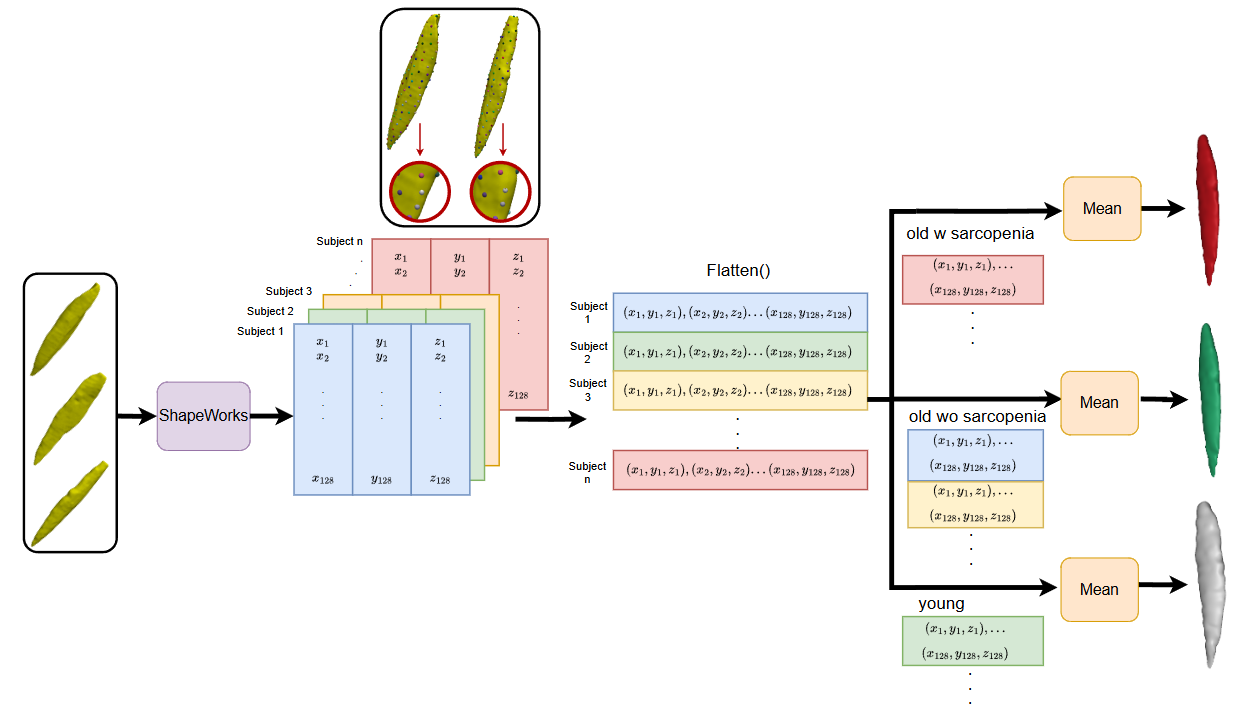




This code allows you to add a group to the ShapeWorks project.

Then, simply go to Analyze → Group → Group Set to choose the group comparison.
⚠️ Be careful to adjust the scale for better visibility.

In [ ]:
import json

# === Parameters ===
# input_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/D_J_128_RF6.swproj"
# output_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/D_J_128_RF_LDA.swproj"
# sick_list_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/sarcopenia_subj_DIASEM.txt"
fichier_entree = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/D_J_128_TA.swproj"
fichier_sortie = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/D_J_128_RF_LDA.swproj"
malade_list_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/sarcopenia_subj_DIASEM.txt"
# input_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/D_J_128_VL.swproj"
# output_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/D_J_128_VL_LDA.swproj"
# sick_list_file = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/sarcopenia_subj_DIASEM.txt"

# List of sick file names (adapt as needed)
# Load sick codes (XXXX)
with open(malade_list_file, "r") as f:
    fichiers_malades = set(line.strip() for line in f if line.strip())


# === Load the swproj file ===
with open(fichier_entree, "r") as f:
    projet = json.load(f)


# === Add groups to each entry in the 'data' list ===
for sujet in projet.get("data", []):
    nom = sujet.get("name", "")
    parts = nom.split("_")
    # if len(parts) >= 2:
    code = parts[0]
    if code in fichiers_malades:
        print(nom)
        sujet["group_ids"] = "sarcopenie"
    elif code not in fichiers_malades and code.lower().startswith("sujet"):
        sujet["group_ids"] = "jeunes"
    else:
        sujet["group_ids"] = "ages"

# === Save the new file ===
with open(fichier_sortie, "w") as f:
    json.dump(projet, f, indent=4)

print(f"Modified file saved as: {fichier_sortie}")


# LDA separation (without train/test)


Linear Discriminant Analysis (LDA) is a linear projection method used to maximize the separation between different classes.
In this work, the correspondence points of all subjects were projected into the space defined by LDA to find a representation that optimizes discrimination between groups (e.g., healthy subjects vs. sarcopenic subjects).

The diagram below illustrates this separation principle:

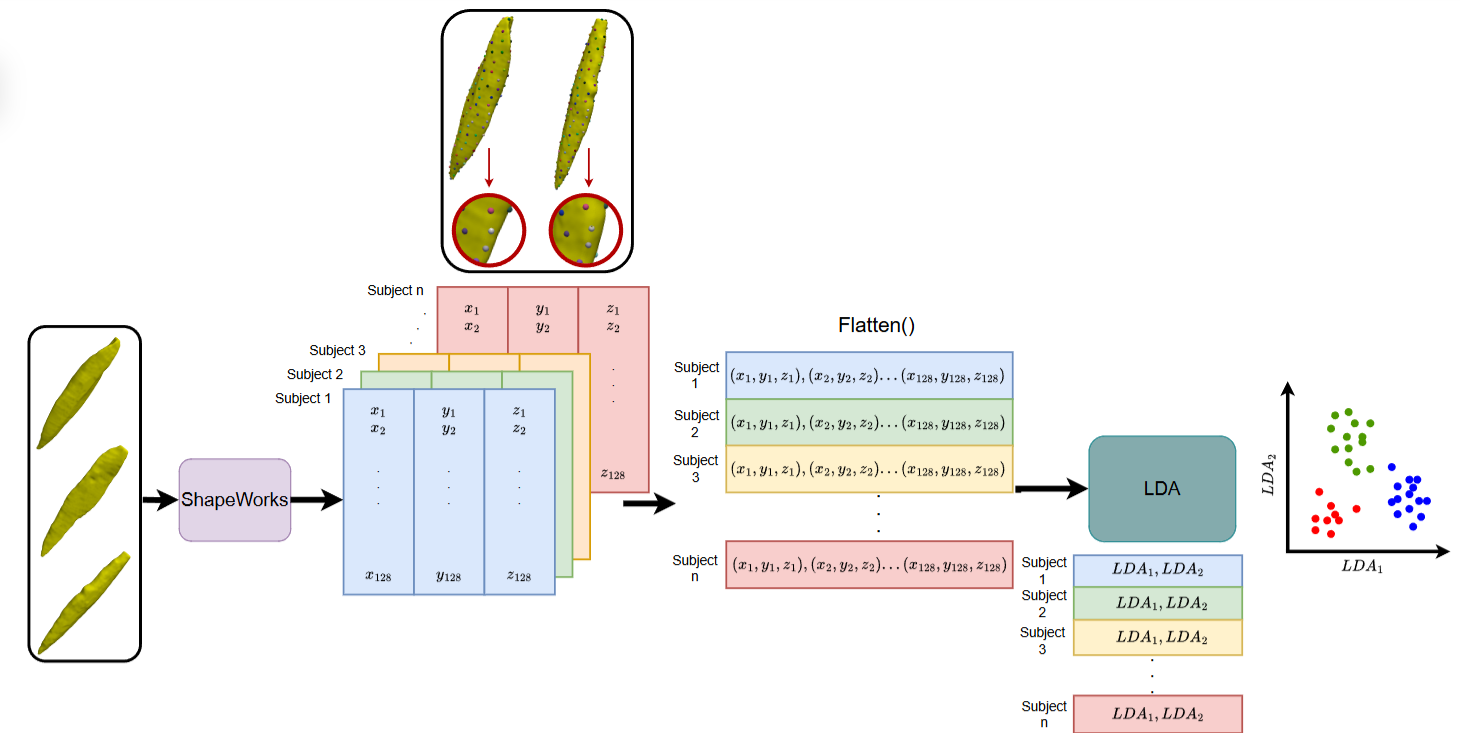

parts_flat_128 shape: 104 samples, 384 features
Fisher score multiclasse (généralisé) : 2.3031
Valeurs propres : [2.5296541  2.07662785]
Fisher score multiclasse (généralisé) exact : 2.3031
Fisher score (jeunes vs âgés) : 1.4495
Fisher score (âgés vs sarcopénique) : 1.6762
Fisher score (jeunes vs sarcopénique) : 1.9991


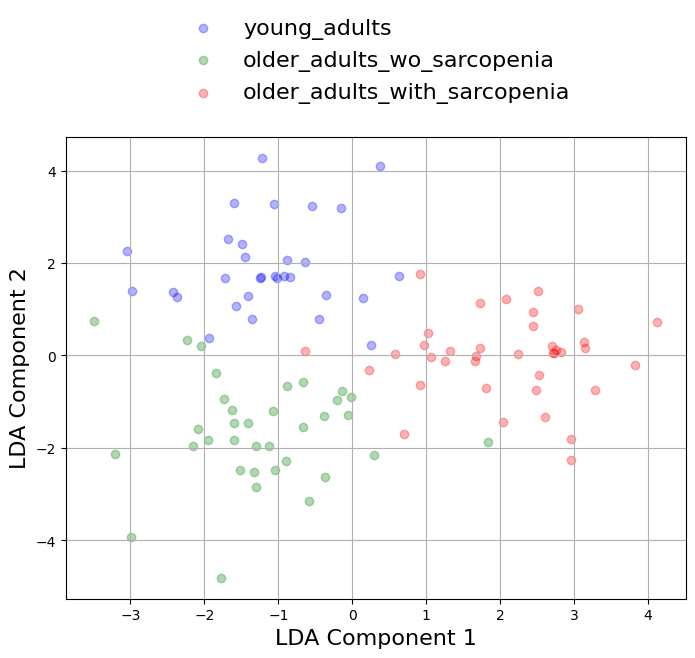

In [ ]:

parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128, sarcopenie_parts_flat_128))
label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128) + [2] * len(sarcopenie_parts_flat_128))  # 0: young, 1: older, 2: sarcopenic
print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

# label_128 = np.random.randint(0, 3, size=len(label_128))  # Generate random labels between 0 and 2


# Apply LDA directly on the data (without PCA)
lda_128 = LDA(n_components=2)
lda_projection_128 = lda_128.fit_transform(parts_flat_128, label_128)


# Compute inter-class and intra-class scatter matrices for the Fisher score
X = lda_projection_128  # LDA projection (n_samples, n_components)
y = label_128           # labels (n_samples,)

classes = np.unique(y)
n_classes = len(classes)
overall_mean = np.mean(X, axis=0)

# Initialize scatter matrices
S_B = np.zeros((X.shape[1], X.shape[1]))
S_W = np.zeros((X.shape[1], X.shape[1]))

for cls in classes:
    X_c = X[y == cls]
    mean_c = np.mean(X_c, axis=0)
    n_c = X_c.shape[0]
  
    # S_B: inter-class scatter
    mean_diff = (mean_c - overall_mean).reshape(-1, 1)
    S_B += n_c * (mean_diff @ mean_diff.T)

    # S_W: intra-class scatter
    cov_c = np.cov(X_c, rowvar=False)  # (d, d)
    S_W += cov_c * (n_c - 1)

# Compute generalized Fisher score
fisher_score_multi = np.trace(S_B) / np.trace(S_W)
print(f"Multiclass Fisher score (generalized): {fisher_score_multi:.4f}")

# Compute eigenvalues for exact Fisher score
eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
print(f"Eigenvalues: {eigvals}")
fisher_score_exact =  np.mean(eigvals) # or max(eigvals) depending on criterion
print(f"Multiclass Fisher score (exact, generalized): {fisher_score_exact:.4f}")

# Compute Fisher ratio for each pair of clusters
# List of class pairs to compare
pairs = [(0, 1), (1, 2), (0, 2)]

label_names = {0: "young_adults", 1: "older_adults_wo_sarcopenia", 2: "older_adults_with_sarcopenia"}

for c1, c2 in pairs:
    # Select indices corresponding to the two classes
    idx = np.where((label_128 == c1) | (label_128 == c2))[0]
    lda_proj_pair = lda_projection_128[idx]
    label_pair = label_128[idx]
    # Compute Fisher score for this pair
    fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
    print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}): {fisher_score:.4f}")


# Visualization of 2D LDA projection
plt.figure(figsize=(8, 6))
for label, label_str, color in zip([0, 1, 2], ['young_adults', 'older_adults_wo_sarcopenia', 'older_adults_with_sarcopenia'], ['blue', 'green', 'red']):
    plt.scatter(lda_projection_128[label_128 == label, 0], lda_projection_128[label_128 == label, 1], 
                c=color, label=f'{label_str}', alpha=0.3, marker='o')

# plt.title(f"LDA projection (without PCA)\nFisher Score: {fisher_score_exact:.2f}", fontsize=18, y=1.3)
plt.xlabel("LDA Component 1", fontsize=16)
plt.ylabel("LDA Component 2", fontsize=16)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=1, frameon=False, fontsize=16)
# Save figure as PDF
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Shape_Diffrence_RF_sans_titre_aleatoire.pdf", format='pdf', bbox_inches='tight')
plt.show()



# Anomaly Detection


Anomaly detection aims to identify atypical muscle shapes compared to the reference population.  
In the context of studying sarcopenic subjects, this approach is particularly relevant because it allows to:  

- detect significant deviations from shapes considered normal,  
- quantify the severity of morphological alterations,  
- and explore the potential of the statistical model as a diagnostic aid tool.  

Various methods have been implemented to evaluate anomalies, including reconstruction error, LDA train/test validation, and supervised classification.


## LDA separation (train/test)

In this section, a **PCA** space is built from healthy muscles to represent the normal variability of shapes.  
Then, a test group composed of normal and sarcopenic subjects is projected into this space.  

The projections from both the training group (normal) and the test group are then fed into a **LDA** to assess whether there is a separation between the two populations.  

The figure below illustrates this process:  

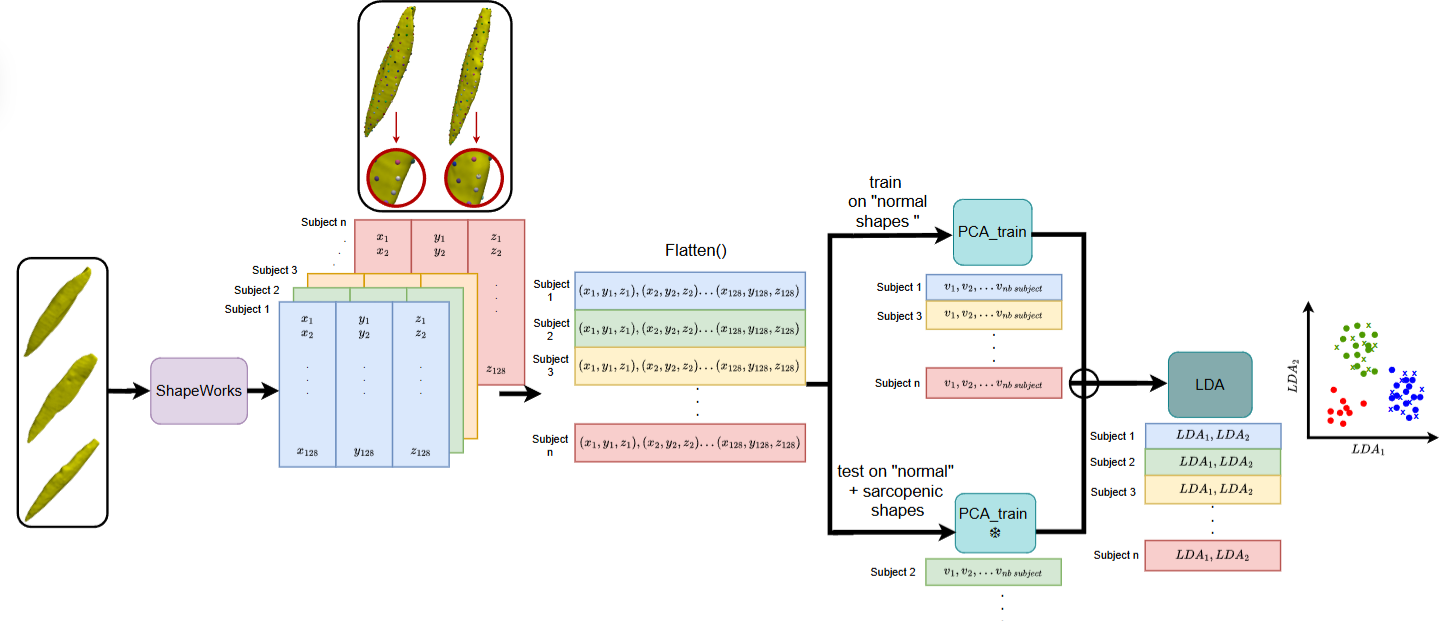

*Overview of the anomaly detection method on correspondence points using the SSM.  
The subjects in the dataset (composed of young adults and older adults without sarcopenia) are used to train the PCA\_train.  
Once trained, PCA\_train is applied to the "normal" shapes as well as the sarcopenic shapes.  
LDA is then applied on this PCA coefficient space to confirm whether there are axes that effectively separate the populations within this space for the training and test subsets.*


parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64


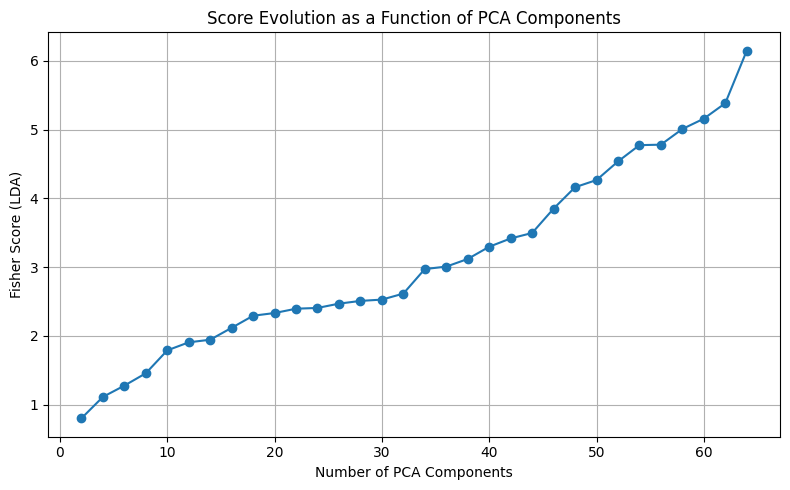

Résultat MANOVA :
P-value globale Wilks' lambda : 3.681974950992172e-18
Fisher score (jeunes vs âgés) : 5.7558
Fisher score (âgés vs sarcopénique) : 1.0564
Fisher score (jeunes vs sarcopénique) : 6.3480


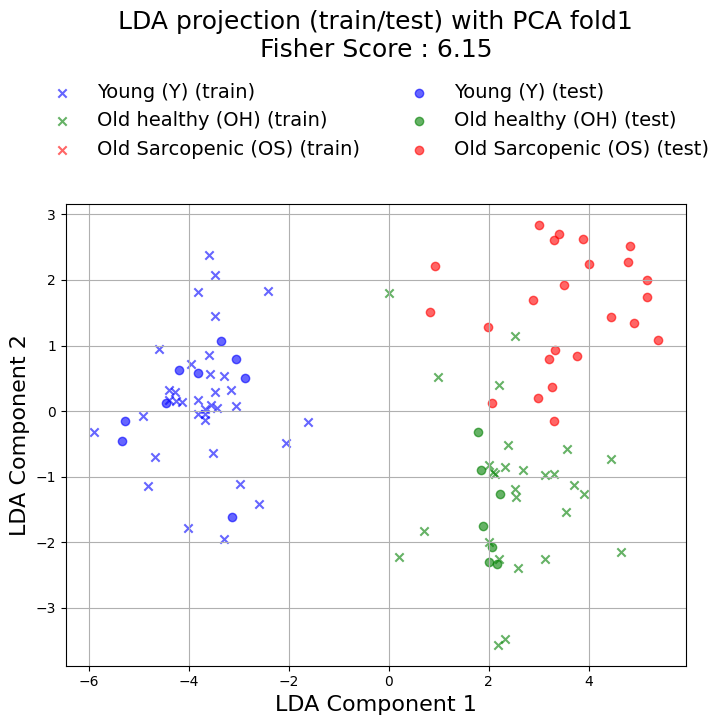

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64


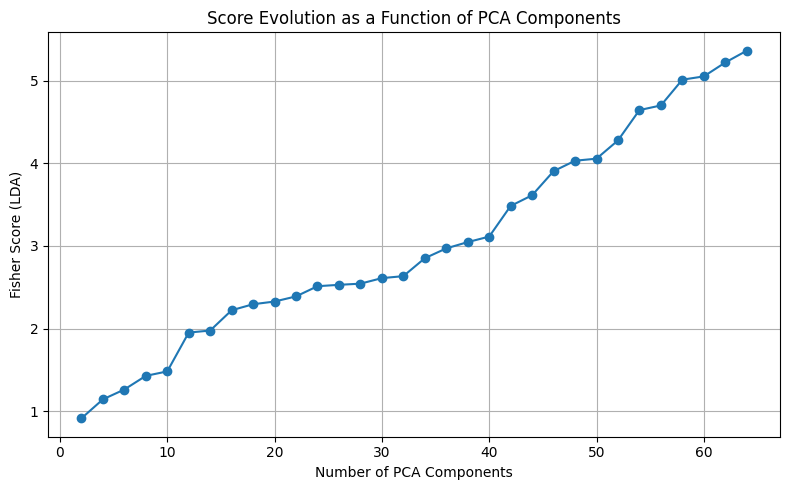

Résultat MANOVA :
P-value globale Wilks' lambda : 3.342798370457951e-19
Fisher score (jeunes vs âgés) : 4.4642
Fisher score (âgés vs sarcopénique) : 1.0438
Fisher score (jeunes vs sarcopénique) : 5.5269


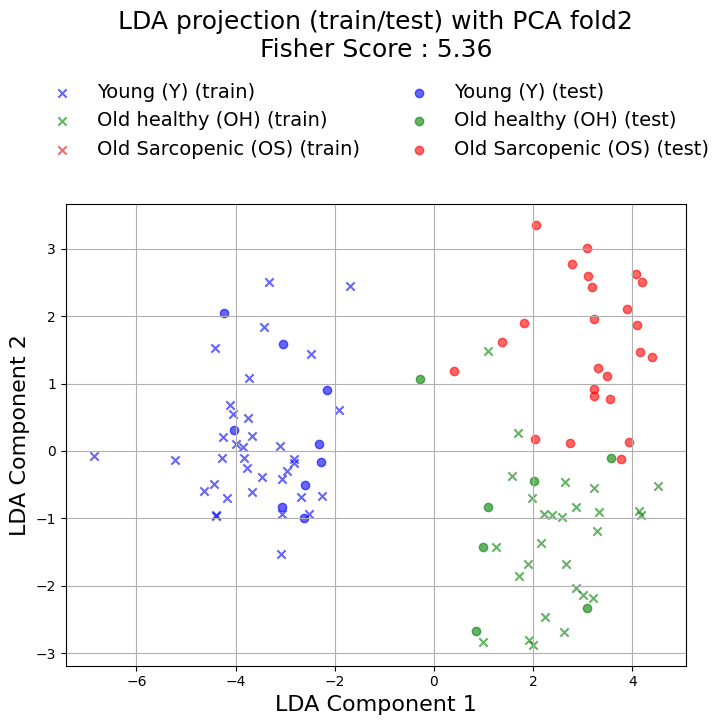

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64


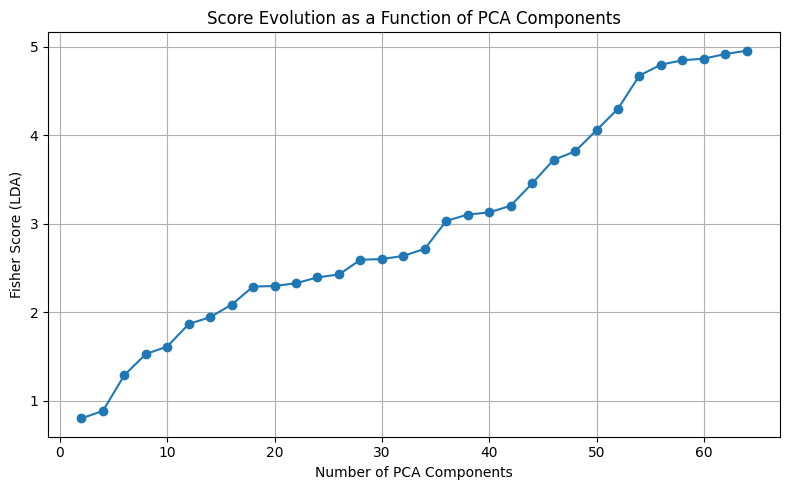

Résultat MANOVA :
P-value globale Wilks' lambda : 2.1510131661181104e-18
Fisher score (jeunes vs âgés) : 4.0874
Fisher score (âgés vs sarcopénique) : 1.0264
Fisher score (jeunes vs sarcopénique) : 4.9579


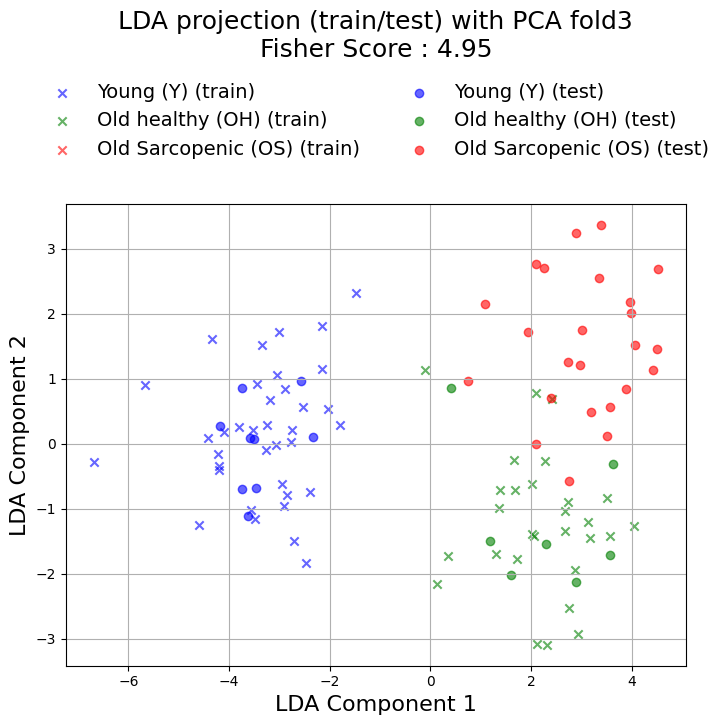

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64


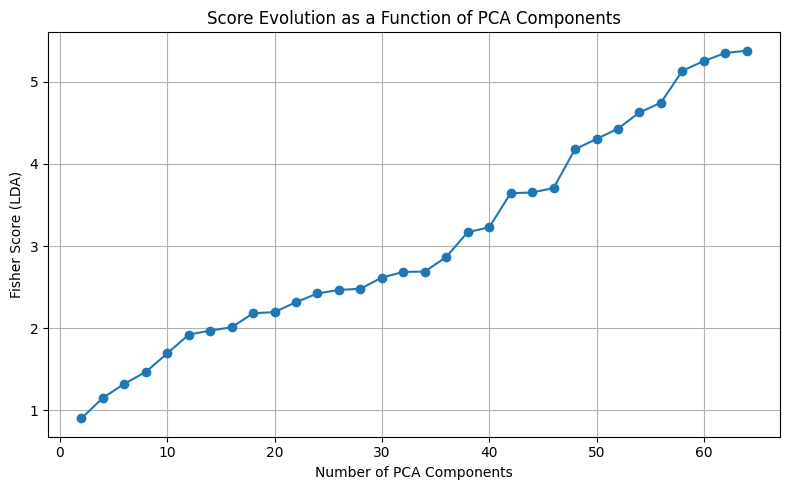

Résultat MANOVA :
P-value globale Wilks' lambda : 3.5459361295239267e-19
Fisher score (jeunes vs âgés) : 4.4140
Fisher score (âgés vs sarcopénique) : 1.1450
Fisher score (jeunes vs sarcopénique) : 5.5693


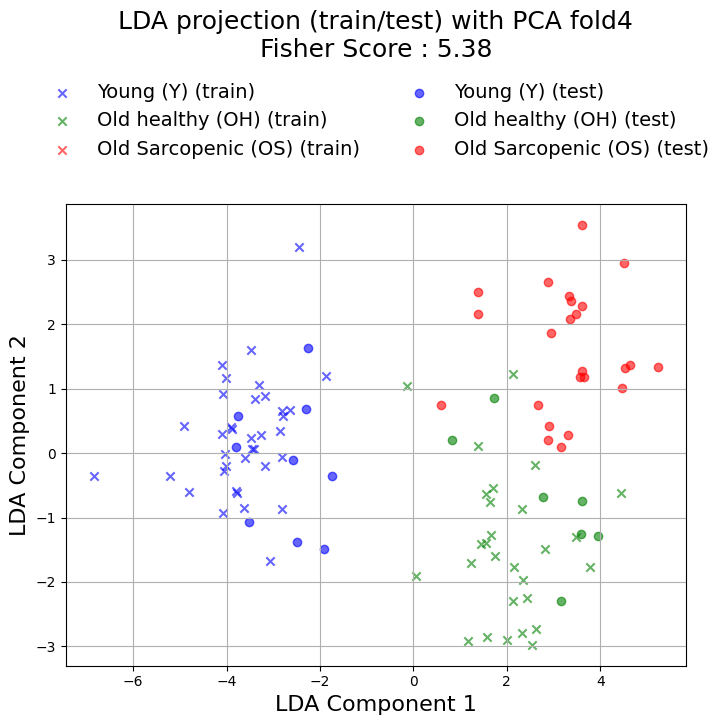

parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Particles ,Best Components : 64


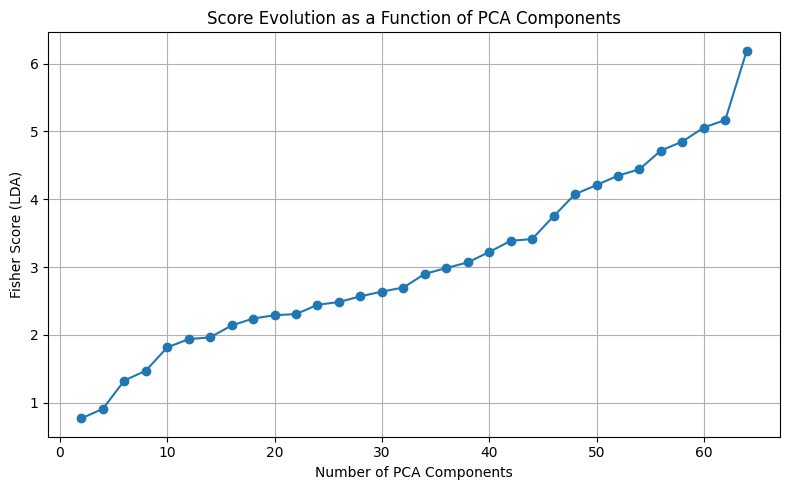

Résultat MANOVA :
P-value globale Wilks' lambda : 1.1680316265211033e-17
Fisher score (jeunes vs âgés) : 5.4707
Fisher score (âgés vs sarcopénique) : 1.4055
Fisher score (jeunes vs sarcopénique) : 5.3280


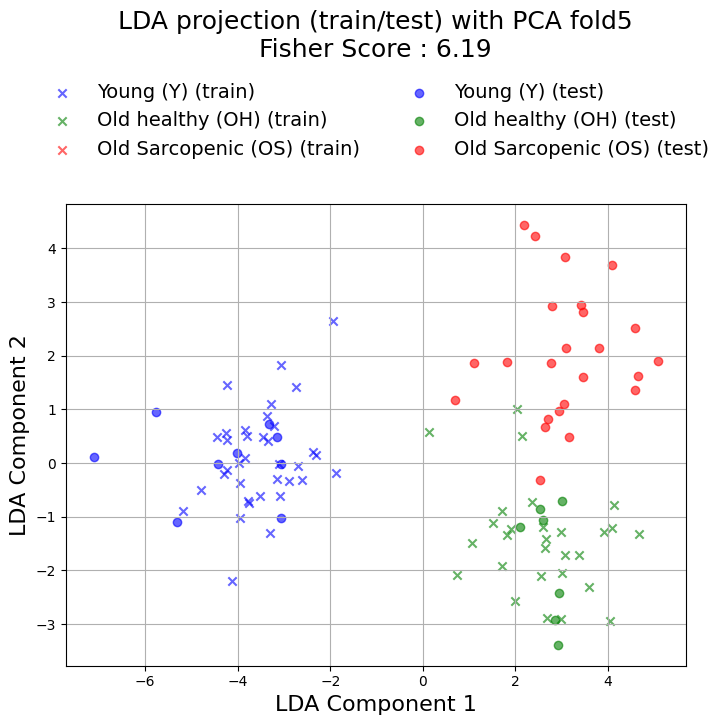

[6.145482420629149, 5.360389811366163, 4.9526311243085575, 5.375863005736571, 6.1912218391761265]


In [ ]:
def train_test_label(particules_train, particules_test):
    # Generate labels for training and test particle files
    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_train)]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_test)]
    test_label = np.concatenate((test_label, [2] * 24))  # Add 24 labels for sarcopenia test particles
    return train_label, test_label

# def compute_fisher_score(lda_projection_128, label_128):
#     # Compute the Fisher score for the LDA projection
#     X = lda_projection_128  # LDA projection (n_samples, n_components)
#     y = label_128           # labels (n_samples,)

#     classes = np.unique(y)
#     n_classes = len(classes)
#     overall_mean = np.mean(X, axis=0)

#     # Between-class and within-class scatter matrices
#     S_B = np.zeros((X.shape[1], X.shape[1]))
#     S_W = np.zeros((X.shape[1], X.shape[1]))

#     for cls in classes:
#         X_c = X[y == cls]
#         mean_c = np.mean(X_c, axis=0)
#         n_c = X_c.shape[0]
    
#         # S_B: between-class scatter
#         mean_diff = (mean_c - overall_mean).reshape(-1, 1)
#         S_B += n_c * (mean_diff @ mean_diff.T)

#         # S_W: within-class scatter
#         cov_c = np.cov(X_c, rowvar=False)  # (d, d)
#         S_W += cov_c * (n_c - 1)

#     # Generalized Fisher ratio
#     fisher_score_multi = np.trace(S_B) / np.trace(S_W)

#     # Eigenvalue calculation for the exact score
#     eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
#     fisher_score_exact = np.mean(eigvals)
#     return fisher_score_exact

# Definition of particle folder paths for different groups
# RF: Particle directories for the RF muscle (Rectus Femoris)
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
particles_dir_train_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train2",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train3",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train4",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train5"]
particles_dir_test_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test2",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test3",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test4",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test5"]

# TA: Directories for the TA muscle (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
# particles_dir_train = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/train"
# particles_dir_test = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/test"

# VL: Directories for the VL muscle (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/Sarcopenie_128"
# particles_dir_train = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/train"
# particles_dir_test = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test29/Run_1/OUTPUT/test"

folds=1
list_fisher_score = []
list_fisher_old_sarco = []
for fold in range(len(particles_dir_train_list)):
    particles_dir_train = particles_dir_train_list[fold]
    particles_dir_test = particles_dir_test_list[fold]
    # Create labels for training and test sets
    train_label, test_label = train_test_label(particles_dir_train, particles_dir_test)

    # Load sarcopenia particles and flatten
    sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
    n, p, d = sarcopenie_parts_128.shape
    sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

    # Load test particles and flatten
    test_parts_128, test_names = get_particles(particles_dir_test, "world")
    n, p, d = test_parts_128.shape
    test_parts_flat_128 = test_parts_128.reshape(n, -1)

    # Load training particles and flatten
    train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
    n, p, d = train_parts_128.shape
    train_parts_flat_128 = train_parts_128.reshape(n, -1)

    # train_label = np.random.randint(0, 2, size=len(train_label))
    # test_label = np.random.randint(0, 3, size=len(test_label))  # Generate random labels between 0 and 2


    # Add sarcopenia particles to the test set
    test_parts_flat_128 = np.vstack((test_parts_flat_128, sarcopenie_parts_flat_128))

    print(f"parts_flat_128 shape (train) : {train_parts_flat_128.shape[0]} samples, {train_parts_flat_128.shape[1]} features")
    print(f"parts_flat_128 shape (test) : {test_parts_flat_128.shape[0]} samples, {test_parts_flat_128.shape[1]} features")
    print(f"label_128 size (train) : {len(train_label)}")
    print(f"label_128 size (test) : {len(test_label)}")

    # Train PCA on training data
    max_components = min(train_parts_flat_128.shape[0], train_parts_flat_128.shape[1])
    scores_128 = []

    print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2)

    for n in component_range:
        # PCA on training data
        pca_128 = PCA(n_components=n)
        pca_train = pca_128.fit_transform(train_parts_flat_128)
        pca_test = pca_128.transform(test_parts_flat_128)

        # Concatenate PCA projections train/test
        pca_projection = np.concatenate((pca_train, pca_test))
        label_128 = np.concatenate((train_label, test_label))

        # LDA projection
        # LDA with 2 components
        lda_128 = LDA(n_components=2)
        lda_projection_128 = lda_128.fit_transform(pca_projection[:, :n], label_128)

        # Compute Fisher score
        score = compute_fisher_score(lda_projection_128, label_128)
        scores_128.append(score)

    # Find the optimal number of PCA components
    best_n_components_128 = component_range[np.argmax(scores_128)]
    best_score = max(scores_128)
    print(f"128 Particles, Best Components : {best_n_components_128}")

    # -------------------------------------------
    # Plot Score vs Components curve
    # -------------------------------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    plt.plot(list(component_range), scores_128, marker='o')
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Fisher Score (LDA)")
    plt.title("Score Evolution as a Function of PCA Components")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_best_PCA_RF.pdf", format='pdf', bbox_inches='tight')

    plt.show()



    # Final PCA and LDA with the best number of components
    pca_128 = PCA(n_components=best_n_components_128)
    pca_train = pca_128.fit_transform(train_parts_flat_128)
    pca_test = pca_128.transform(test_parts_flat_128)
    pca_projection = np.concatenate((pca_train, pca_test))
    label_128 = np.concatenate((train_label, test_label))

    lda_projection_128 = lda_128.fit_transform(pca_projection, label_128)
    fisher_score_exact = compute_fisher_score(lda_projection_128, label_128)
    # Split LDA projections for train and test
    lda_train = lda_projection_128[:len(train_label), :]
    lda_test = lda_projection_128[len(train_label):, :]

    import pandas as pd
    from statsmodels.multivariate.manova import MANOVA
    # Assume lda_projection_128 contains the 2 LDA axes
    z_lda = pca_projection  # shape (n_samples, 2)
    y = label_128  # class labels

    # z_lda = lda_projection_128  # shape (n_samples, 2)
    # y = label_128  # class labels

    # Create a DataFrame for MANOVA
    df_anova = pd.DataFrame({
        "LDA1": z_lda[:, 0],
        "LDA2": z_lda[:, 1],
        "Group": y
    })

    # Multivariate MANOVA: global test of both axes simultaneously
    maov = MANOVA.from_formula('LDA1 + LDA2 ~ Group', data=df_anova)
    manova_res = maov.mv_test()

    # Global p-value (Wilks' lambda)
    p_value = manova_res.results['Group']['stat']['Pr > F']["Wilks' lambda"]

    print("MANOVA result:")
    # print(manova_res)
    print(f"Global p-value Wilks' lambda : {p_value}")



    # Compute the Fisher ratio for each pair of clusters
    # List of class pairs to compare
    pairs = [(0, 1), (1, 2), (0, 2)]

    label_names = {0: "young", 1: "old", 2: "sarcopenic"}
    fisher_score_tab = []
    for c1, c2 in pairs:
        # Select indices corresponding to the two classes
        idx = np.where((label_128 == c1) | (label_128 == c2))[0]
        lda_proj_pair = lda_projection_128[idx]
        label_pair = label_128[idx]
        # Compute the Fisher score for this pair
        fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
        print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")
        fisher_score_tab.append(fisher_score)
        # print(fisher_score)

    list_fisher_old_sarco.append(fisher_score_tab)
    # 2D visualization of LDA results
    plt.figure(figsize=(8, 6))

    # Training data
    for label, label_str, color in zip([0, 1, 2], ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
        plt.scatter(lda_train[np.array(train_label) == label, 0], lda_train[np.array(train_label) == label, 1],
                    c=color, alpha=0.6, marker='x', label=f'{label_str} (train)')

    # Test data
    for label, label_str, color in zip([0, 1, 2],  ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
        plt.scatter(lda_test[np.array(test_label) == label, 0], lda_test[np.array(test_label) == label, 1],
                    c=color, alpha=0.6, marker='o', label=f'{label_str} (test)')

    plt.title(f"LDA projection (train/test) with PCA fold{folds}\nFisher Score : {fisher_score_exact:.2f}", fontsize=18, y=1.3)
    plt.xlabel("LDA Component 1", fontsize=16)
    plt.ylabel("LDA Component 2", fontsize=16)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, fontsize=14)
    plt.grid(True)
    plt.savefig(f"C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_RF_{folds}.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    list_fisher_score.append(fisher_score_exact)
    folds+=1

print(list_fisher_score)

# # Direct transformation to numpy array
# scores_array = np.array(list_fisher_old_sarco)  # shape: (3 groups, 3 variables, n_samples)
# print(scores_array.shape)
# # Data reorganization
# n_groups, n_variables, n_samples = scores_array.shape
# data = {
#     'Score1': scores_array[:, 0, :].flatten(),
#     'Score2': scores_array[:, 1, :].flatten(), 
#     'Score3': scores_array[:, 2, :].flatten(),
#     'Group': np.repeat(['Dist1', 'Dist2', 'Dist3'], n_samples)
# }

# df_manova = pd.DataFrame(data)

# # MANOVA
# maov = MANOVA.from_formula('Score1 + Score2 + Score3 ~ Group', data=df_manova)
# manova_res = maov.mv_test()
# p_value = manova_res.results['Group']['stat']['Pr > F']["Wilks' lambda"]

# print("MANOVA result:")
# print(manova_res)
# print(f"\nGlobal p-value Wilks' lambda : {p_value:.6f}")

### Influence of PCA Axes on LDA Separation

Analyzing the influence of each **PCA** axis on the separation achieved by **LDA** helps to understand which shape variations are most discriminative between groups.

Specifically:

* **PCA** captures the main directions of variability in muscle shapes, without considering class labels.
* **LDA** then projects these data into a space where the separation between groups (normal and sarcopenic) is maximized.

Studying the impact of each PCA axis on LDA thus identifies **which anatomical variations contribute most to the discrimination between populations**.
This provides a better biological interpretation of the model by directly linking certain dimensions of shape variability to observed clinical differences.


Composante PCA 64 : importance 32.26%
Composante PCA 48 : importance 5.23%
Composante PCA 52 : importance 4.16%
Composante PCA 61 : importance 3.53%
Composante PCA 62 : importance 3.50%
Composante PCA 46 : importance 3.36%
Composante PCA 49 : importance 3.08%
Composante PCA 34 : importance 3.04%
Composante PCA 37 : importance 2.39%
Composante PCA 63 : importance 2.05%
Composante PCA 60 : importance 1.97%
Composante PCA 58 : importance 1.77%
Composante PCA 39 : importance 1.76%
Composante PCA 54 : importance 1.70%
Composante PCA 53 : importance 1.69%
Composante PCA 31 : importance 1.50%
Composante PCA 44 : importance 1.49%
Composante PCA 50 : importance 1.41%
Composante PCA 33 : importance 1.41%
Composante PCA 38 : importance 1.24%
Composante PCA 59 : importance 1.21%
Composante PCA 51 : importance 1.20%
Composante PCA 28 : importance 1.09%
Composante PCA 55 : importance 1.03%
Composante PCA 40 : importance 1.02%
Composante PCA 16 : importance 1.00%
Composante PCA 56 : importance 0.93%


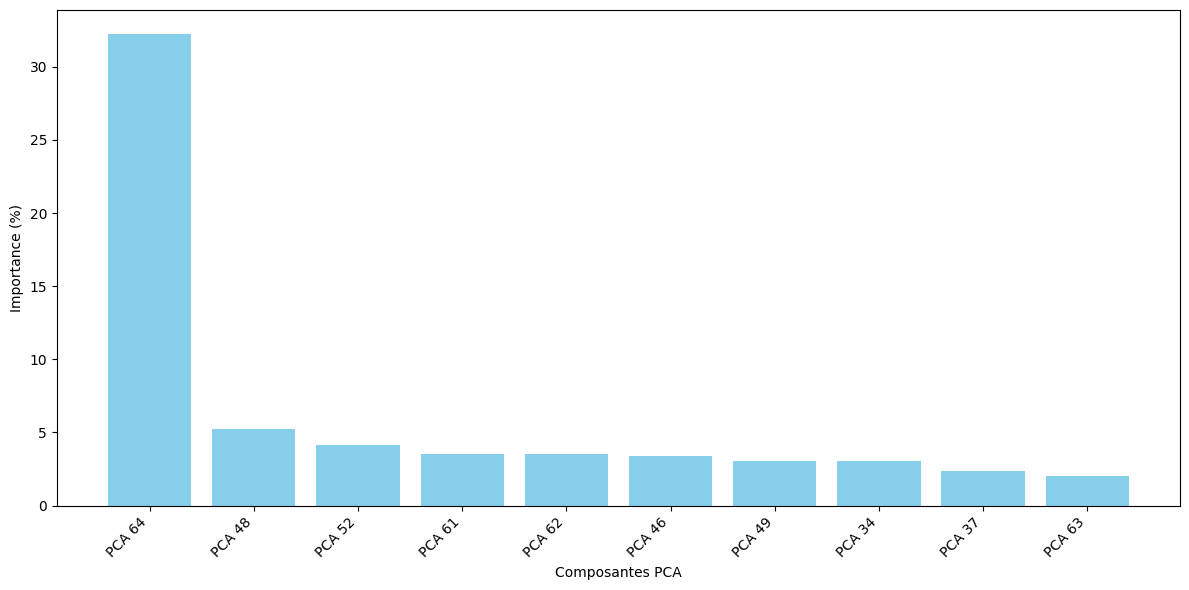

In [ ]:
# Weight of the LDA direction in the PCA space
lda_weights = lda_128.coef_[0]

# Relative importance of PCA components
importance = np.abs(lda_weights) / np.sum(np.abs(lda_weights))

# Sorted display
sorted_importance = sorted(enumerate(importance), key=lambda x: -x[1])
# Display sorted
for i, imp in sorted(enumerate(importance), key=lambda x: -x[1]):
    print(f"PCA component {i+1} : importance {imp:.2%}")
print(f"Sum of importances : {np.sum(importance):.2%}")

# Display the most important components as a histogram
components = [f"PCA {i+1}" for i, _ in sorted_importance]
values = [imp*100 for _, imp in sorted_importance]

plt.figure(figsize=(12, 6))
plt.bar(components[:10], values[:10], color='skyblue')  # Display the top 10 components
plt.xticks(rotation=45, ha='right')
plt.xlabel("PCA Components")
plt.ylabel("Importance (%)")
# plt.title("Importance of PCA Components (Top 10)")
plt.tight_layout()
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_Importance_RF.pdf", format='pdf', bbox_inches='tight')

plt.show()


### P-Value on PCA

_RF
sarcopenie_parts_128 shape : ['Malades_AL135_RF_world', 'Malades_AM112_RF_label_world', 'Malades_BA137_RF_label_world', 'Malades_BM103_RF_label_world', 'Malades_CY164_RF_seg_world', 'Malades_DI154_RF_label_world', 'Malades_DP172_RF_label_world', 'Malades_DR160_RF_label_world', 'Malades_EM151_RF_label_world', 'Malades_EP105_RF_label_world', 'Malades_FO117_RF_label_world', 'Malades_GD171_RF_label_world', 'Malades_LA134_RF_label_world', 'Malades_LA162_RF_label_world', 'Malades_LJ139_RF_label_world', 'Malades_LP133_RF_label_world', 'Malades_MA119_RF_label_world', 'Malades_MM170_RF_label_world', 'Malades_PG161_RF_label_world', 'Malades_PP104_RF_label_world', 'Malades_QP108_RF_label_world', 'Malades_RA150_RF_label_world', 'Malades_RJ136_RF_label_world', 'Malades_SC146_RF_label_world']
particles_dir_train : ['Jeunes_sujet10_RF_faible_3DUS_label_world.particles', 'Jeunes_sujet10_RF_fort_3DUS_label_world.particles', 'Jeunes_sujet10_RF_pad_3DUS_label_world.particles', 'Jeunes_sujet11_RF_faib

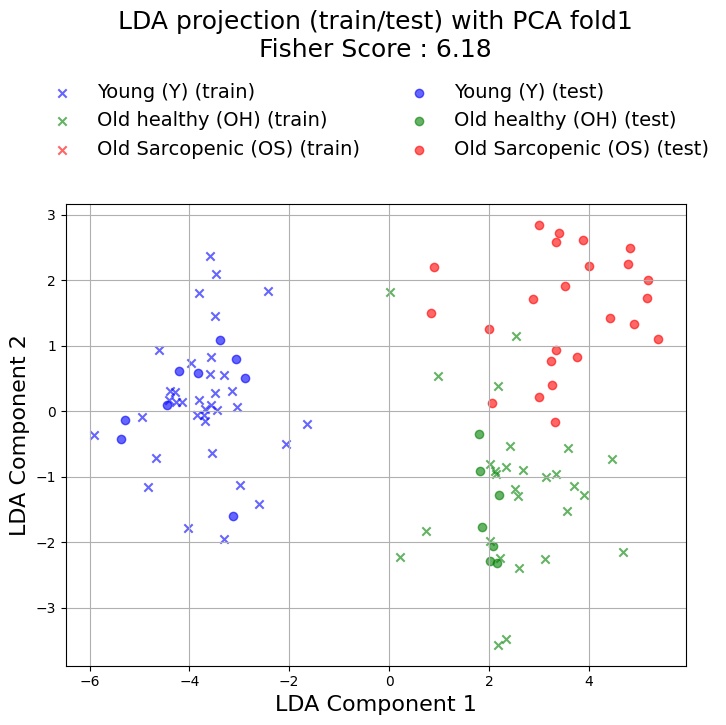

[6.175318947288757]
_TA
sarcopenie_parts_128 shape : ['Malades_AL135_TA_seg_world', 'Malades_AM112_TA_seg_world', 'Malades_BA137_TA_seg_world', 'Malades_BM103_TA_seg_world', 'Malades_DI154_TA_seg_world', 'Malades_DR160_TA_seg_world', 'Malades_EM151_TA_seg_world', 'Malades_EP105_TA_seg_world', 'Malades_FO117_TA_seg_world', 'Malades_GD171_TA_seg_world', 'Malades_LA134_TA_seg_world', 'Malades_LA162_TA_seg_world', 'Malades_LJ139_TA_seg_world', 'Malades_LP133_TA_seg_world', 'Malades_MA119_TA_seg_world', 'Malades_MM170_TA_seg_world', 'Malades_PG161_TA_seg_world', 'Malades_PP104_TA_seg_world', 'Malades_QP108_TA_seg_world', 'Malades_RA150_TA_seg_world', 'Malades_RJ136_TA_seg_world', 'Malades_SC146_TA_seg_world']
particles_dir_train : ['Jeunes_sujet10_RF_faible_3DUS_label_world.particles', 'Jeunes_sujet10_RF_fort_3DUS_label_world.particles', 'Jeunes_sujet10_RF_pad_3DUS_label_world.particles', 'Jeunes_sujet11_RF_faible_3DUS_label_world.particles', 'Jeunes_sujet11_RF_fort_3DUS_label_world.particl

ValueError: Found input variables with inconsistent numbers of samples: [102, 69]

In [ ]:
def train_test_label(particules_dir_train, particules_dir_test, jeunes_names, vieu_names, sarcopenie_names, sufix):
    # Generate labels for train and test particle files
    print(f"particles_dir_train contents: {os.listdir(particules_dir_train)} ")
    print(f"young dir: {jeunes_names} ")
    # particles_train = [name for name in os.listdir(particles_dir_train) if name in jeunes_names or name in vieu_names]
    dir_train = os.listdir(particles_dir_train)
    dir_test = os.listdir(particles_dir_test)

    def normalize_name(name: str) -> str:
        # Remove extension
        base = os.path.splitext(name)[0]
        # Replace _RF with suffix
        base = base.replace('_RF', sufix)
        # Keep only the first 4 segments
        parts = base.split('_')
        return '_'.join(parts[:4])
    
    jeunes_names = ['_'.join(name.split('_')[:4]) for name in jeunes_names]
    vieu_names = ['_'.join(name.split('_')[:4]) for name in vieu_names]
    sarcopenie_names = ['_'.join(name.split('_')[:4]) for name in sarcopenie_names]

    particles_train = [
        os.path.splitext(name)[0].replace('_RF', sufix)
        for name in os.listdir(particles_dir_train)
        if normalize_name(name) in jeunes_names or normalize_name(name) in vieu_names
    ]
    print(f"particles_train: {particles_train} ")

    particles_test = [
        normalize_name(name)
        for name in os.listdir(particles_dir_test)
        if normalize_name(name) in jeunes_names
        or normalize_name(name) in vieu_names
        or normalize_name(name) in sarcopenie_names
    ]
    # particles_test = [name for name in particles_dir_test if name in jeunes_names or name in vieu_names or name in sarcopenie_names]
    

    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in particles_train]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in particles_test]
    try :
        test_label = np.concatenate((test_label, [2] * 24))  # Add 24 labels for sarcopenic test particles
    except:
        test_label = np.concatenate((test_label, [2] * 22))  # Fallback: add 22 labels for sarcopenic test particles
    print(len(train_label))    
    print(len(test_label))
    return train_label, test_label

# def compute_fisher_score(lda_projection_128, label_128):
#     # Compute the Fisher score for the LDA projection
#     X = lda_projection_128  # LDA projection (n_samples, n_components)
#     y = label_128           # labels (n_samples,)

#     classes = np.unique(y)
#     n_classes = len(classes)
#     overall_mean = np.mean(X, axis=0)

#     # Between-class and within-class scatter matrices
#     S_B = np.zeros((X.shape[1], X.shape[1]))
#     S_W = np.zeros((X.shape[1], X.shape[1]))

#     for cls in classes:
#         X_c = X[y == cls]
#         mean_c = np.mean(X_c, axis=0)
#         n_c = X_c.shape[0]
    
#         # S_B: between-class scatter
#         mean_diff = (mean_c - overall_mean).reshape(-1, 1)
#         S_B += n_c * (mean_diff @ mean_diff.T)

#         # S_W: within-class scatter
#         cov_c = np.cov(X_c, rowvar=False)  # (d, d)
#         S_W += cov_c * (n_c - 1)

#     # Generalized Fisher ratio
#     fisher_score_multi = np.trace(S_B) / np.trace(S_W)

#     # Exact score via eigenvalues
#     eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
#     fisher_score_exact = np.mean(eigvals)
#     return fisher_score_exact

# RF: Directories of particles for the RF muscle (Rectus Femoris)
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
particles_dir_train_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train2",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train3",
                        "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train4"]
particles_dir_test_list = ["C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test2",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test3",
                          "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test4"]

# Paths for each muscle
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
}



def compute_LDA(particles_dir_sarcopenie_128, particles_dir_jeunes_128, particles_dir_vieu_128, particles_dir_train_list, particles_dir_test_list, n_components, sufix):
    print(f"suffix: {sufix}")

    folds=1
    list_fisher_score = []
    list_fisher_old_sarco = []
    for fold in range(1):#len(particles_dir_train_list)):
        particles_dir_train = particles_dir_train_list[fold]
        particles_dir_test = particles_dir_test_list[fold]
        

        # Load sarcopenic particles and flatten
        sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
        print(f"sarcopenie_parts_128 names: {sarcopenie_names}")
        n, p, d = sarcopenie_parts_128.shape
        sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

        # Load test particles and flatten
        test_parts_128, test_names = get_particles(particles_dir_test, "world")
        n, p, d = test_parts_128.shape
        test_parts_flat_128 = test_parts_128.reshape(n, -1)

        # Load training particles and flatten
        train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
        n, p, d = train_parts_128.shape
        train_parts_flat_128 = train_parts_128.reshape(n, -1)

        # train_label = np.random.randint(0, 2, size=len(train_label))
        # test_label = np.random.randint(0, 3, size=len(test_label))  # Generate random labels between 0 and 2
        
        jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
        vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")

        # Add sarcopenic particles to the test set
        test_parts_flat_128 = np.vstack((test_parts_flat_128, sarcopenie_parts_flat_128))

        
        # Create labels for training and testing
        train_label, test_label = train_test_label(particles_dir_train, particles_dir_test, jeunes_names, vieu_names, sarcopenie_names, sufix)

        print(f"parts_flat_128 shape (train) : {train_parts_flat_128.shape[0]} samples, {train_parts_flat_128.shape[1]} features")
        print(f"parts_flat_128 shape (test) : {test_parts_flat_128.shape[0]} samples, {test_parts_flat_128.shape[1]} features")
        print(f"size of label_128 (train) : {len(train_label)}")
        print(f"size of label_128 (test) : {len(test_label)}")

        # Train PCA on the training data
        max_components = min(train_parts_flat_128.shape[0], train_parts_flat_128.shape[1])
        scores_128 = []

        print(f"Training PCA with {max_components} components")
        component_range = range(2, max_components + 1, 2)

        for n in component_range:
            # PCA on training data
            pca_128 = PCA(n_components=n)
            pca_train = pca_128.fit_transform(train_parts_flat_128)
            pca_test = pca_128.transform(test_parts_flat_128)

            # Concatenate PCA projections train/test
            pca_projection = np.concatenate((pca_train, pca_test))
            print(f"PCA projection shape: {pca_projection.shape}")
            label_128 = np.concatenate((train_label, test_label))
            print(f"label_128 shape: {label_128.shape}")

            # LDA projection
            # LDA with 2 components
            lda_128 = LDA(n_components=2)
            lda_projection_128 = lda_128.fit_transform(pca_projection[:, :n], label_128)

            # Compute Fisher score
            score = compute_fisher_score(lda_projection_128, label_128)
            scores_128.append(score)

        # Find the optimal number of PCA components
        best_n_components_128 = component_range[np.argmax(scores_128)]
        best_score = max(scores_128)
        print(f"128 Particles, Best Components : {best_n_components_128}")

        # Final PCA and LDA with the best number of components
        pca_128 = PCA(n_components=best_n_components_128)
        pca_train = pca_128.fit_transform(train_parts_flat_128)
        pca_test = pca_128.transform(test_parts_flat_128)
        pca_projection = np.concatenate((pca_train, pca_test))
        label_128 = np.concatenate((train_label, test_label))

        lda_projection_128 = lda_128.fit_transform(pca_projection, label_128)
        fisher_score_exact = compute_fisher_score(lda_projection_128, label_128)
        # Split LDA projections into train and test
        lda_train = lda_projection_128[:len(train_label), :]
        lda_test = lda_projection_128[len(train_label):, :]

        
        # Compute Fisher ratio for each pair of clusters
        # List of class pairs to compare
        pairs = [(0, 1), (1, 2), (0, 2)]

        label_names = {0: "young", 1: "old healthy", 2: "sarcopenic"}
        fisher_score_tab = []
        for c1, c2 in pairs:
            # Select indices corresponding to the two classes
            idx = np.where((label_128 == c1) | (label_128 == c2))[0]
            lda_proj_pair = lda_projection_128[idx]
            label_pair = label_128[idx]
            # Compute the Fisher score for this pair
            fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
            print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")
            fisher_score_tab.append(fisher_score)
            # print(fisher_score)

        list_fisher_old_sarco.append(fisher_score_tab)
        # Visualize LDA results in 2D
        plt.figure(figsize=(8, 6))

        # Training data
        for label, label_str, color in zip([0, 1, 2], ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
            plt.scatter(lda_train[np.array(train_label) == label, 0], lda_train[np.array(train_label) == label, 1],
                        c=color, alpha=0.6, marker='x', label=f'{label_str} (train)')

        # Test data
        for label, label_str, color in zip([0, 1, 2],  ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
            plt.scatter(lda_test[np.array(test_label) == label, 0], lda_test[np.array(test_label) == label, 1],
                        c=color, alpha=0.6, marker='o', label=f'{label_str} (test)')

        plt.title(f"LDA projection (train/test) with PCA fold{folds}\nFisher Score : {fisher_score_exact:.2f}", fontsize=18, y=1.3)
        plt.xlabel("LDA Component 1", fontsize=16)
        plt.ylabel("LDA Component 2", fontsize=16)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, fontsize=14)
        plt.grid(True)
        plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_VL_sans_titre.pdf", format='pdf', bbox_inches='tight')
        plt.show()
        list_fisher_score.append(fisher_score_exact)
        folds+=1

    print("Fisher scores:", list_fisher_score)


RF
sarcopenie_parts_128 shape : ['Malades_AL135_RF_world', 'Malades_AM112_RF_label_world', 'Malades_BA137_RF_label_world', 'Malades_BM103_RF_label_world', 'Malades_CY164_RF_seg_world', 'Malades_DI154_RF_label_world', 'Malades_DP172_RF_label_world', 'Malades_DR160_RF_label_world', 'Malades_EM151_RF_label_world', 'Malades_EP105_RF_label_world', 'Malades_FO117_RF_label_world', 'Malades_GD171_RF_label_world', 'Malades_LA134_RF_label_world', 'Malades_LA162_RF_label_world', 'Malades_LJ139_RF_label_world', 'Malades_LP133_RF_label_world', 'Malades_MA119_RF_label_world', 'Malades_MM170_RF_label_world', 'Malades_PG161_RF_label_world', 'Malades_PP104_RF_label_world', 'Malades_QP108_RF_label_world', 'Malades_RA150_RF_label_world', 'Malades_RJ136_RF_label_world', 'Malades_SC146_RF_label_world']
parts_flat_128 shape (tain) : 64 samples, 384 features
parts_flat_128 shape (test) : 40 samples, 384 features
taille label_128 (train) : 64
taille label_128 (test) : 40
Training PCA with 64 components
128 Pa

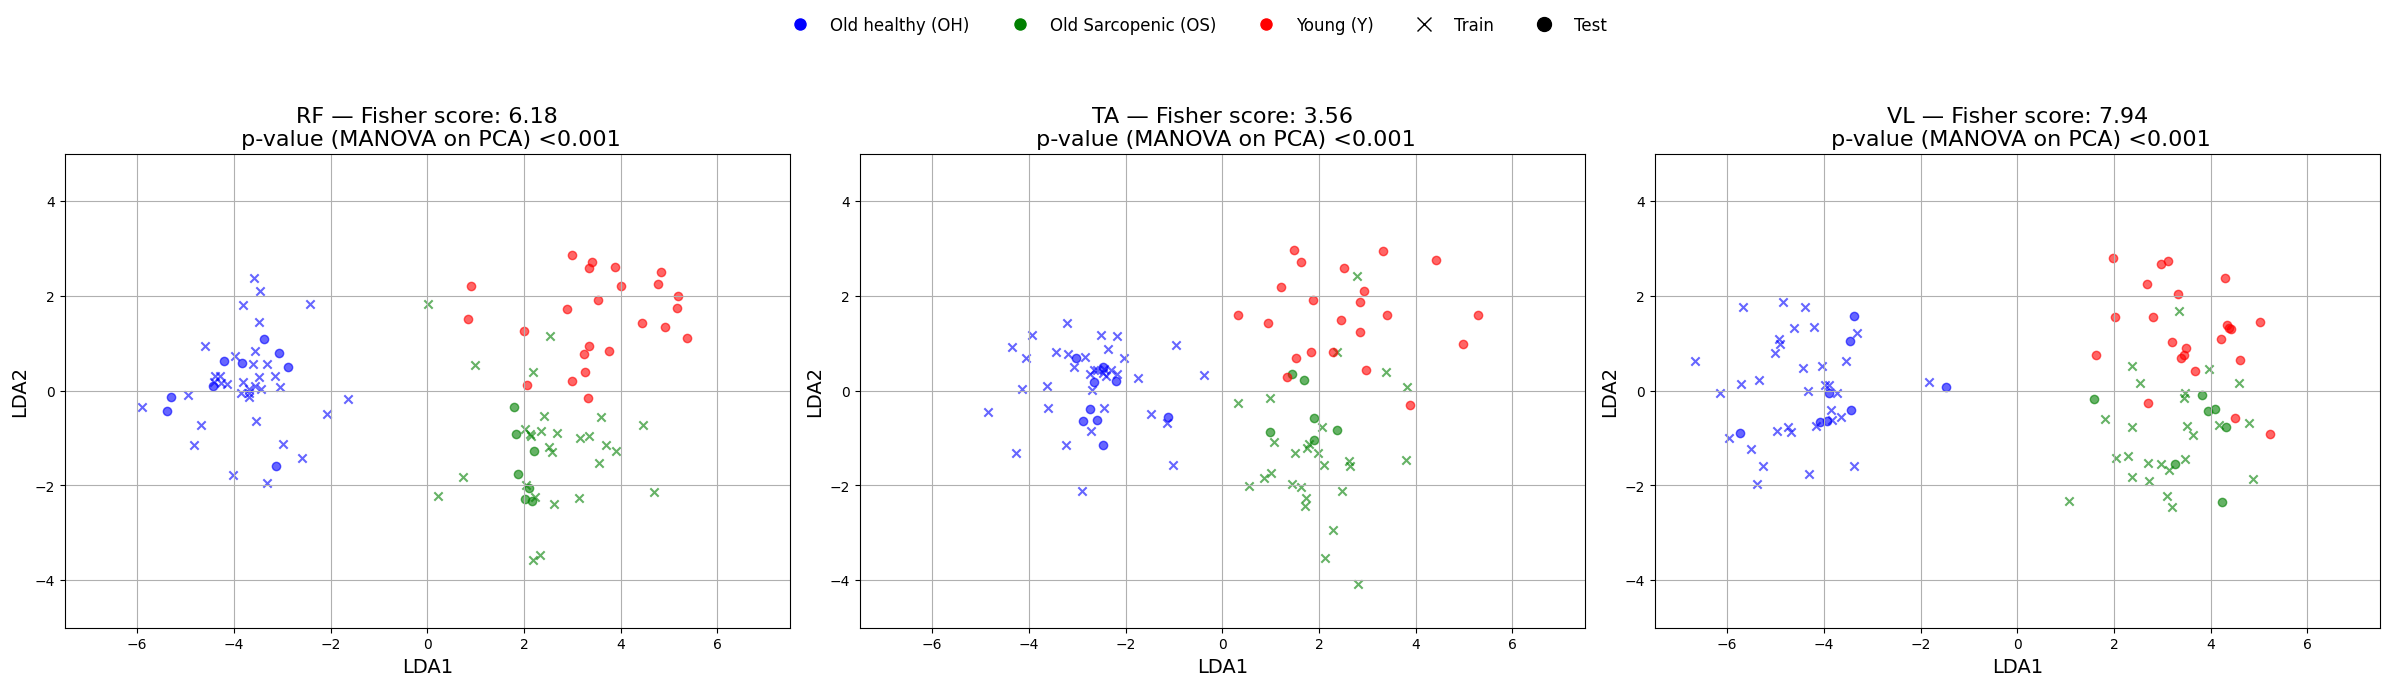

In [ ]:
# Data paths (adapt according to desired muscle)
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128",
    "train": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/train",
    "test": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/test"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128",
    "train": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/train",
    "test": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/test"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128",
    "train": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/train",
    "test": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/test"
}

def train_test_label(particules_train, particules_test, nb_sarco):
    # Generate labels for training and test particle files
    train_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_train)]
    test_label = [0 if "Jeunes" in file else 1 if "Malades" in file else 2 for file in os.listdir(particules_test)]
    test_label = np.concatenate((test_label, [2] * nb_sarco))  # Add nb_sarco labels for sarcopenia test particles
    
    return train_label, test_label



def compute_LDA(particles_dir_sarcopenie_128, particles_dir_jeunes_128, particles_dir_vieu_128, particles_dir_train, particles_dir_test, n_components, sufix, nb_sarco):
    print(sufix)

    folds=1
    list_fisher_score = []
    list_fisher_old_sarco = []
    

    # Load sarcopenia particles and flatten
    sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
    print(f"sarcopenie_parts_128 names : {sarcopenie_names}")
    n, p, d = sarcopenie_parts_128.shape
    sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)

    # Load test particles and flatten
    test_parts_128, test_names = get_particles(particles_dir_test, "world")
    n, p, d = test_parts_128.shape
    test_parts_flat_128 = test_parts_128.reshape(n, -1)

    # Load training particles and flatten
    train_parts_128, vieu_names = get_particles(particles_dir_train, "world")
    n, p, d = train_parts_128.shape
    train_parts_flat_128 = train_parts_128.reshape(n, -1)

    # train_label = np.random.randint(0, 2, size=len(train_label))
    # test_label = np.random.randint(0, 3, size=len(test_label))  # Generate random labels between 0 and 2
    
    jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
    vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")

    # Add sarcopenia particles to the test set
    test_parts_flat_128 = np.vstack((test_parts_flat_128, sarcopenie_parts_flat_128))

    
    # Create labels for training and test
    train_label, test_label = train_test_label(particles_dir_train, particles_dir_test,nb_sarco)

    if test_label.shape[0] != test_parts_flat_128.shape[0]:
        test_label = test_label[:test_parts_flat_128.shape[0]]

    print(f"parts_flat_128 shape (train) : {train_parts_flat_128.shape[0]} samples, {train_parts_flat_128.shape[1]} features")
    print(f"parts_flat_128 shape (test) : {test_parts_flat_128.shape[0]} samples, {test_parts_flat_128.shape[1]} features")
    print(f"label_128 size (train) : {len(train_label)}")
    print(f"label_128 size (test) : {len(test_label)}")

    # Train PCA on training data
    max_components = min(train_parts_flat_128.shape[0], train_parts_flat_128.shape[1])
    scores_128 = []
    print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1, 2)

    for n in component_range:
        # PCA on training data
        pca_128 = PCA(n_components=n)
        pca_train = pca_128.fit_transform(train_parts_flat_128)
        pca_test = pca_128.transform(test_parts_flat_128)

        # Concatenate PCA projections train/test
        pca_projection = np.concatenate((pca_train, pca_test))
        label_128 = np.concatenate((train_label, test_label))

        # LDA projection
        # LDA with 2 components
        lda_128 = LDA(n_components=2)
        lda_projection_128 = lda_128.fit_transform(pca_projection[:, :n], label_128)

        # Compute Fisher score
        score = compute_fisher_score(lda_projection_128, label_128)
        scores_128.append(score)

    # Search for optimal number of PCA components
    best_n_components_128 = component_range[np.argmax(scores_128)]
    best_score = max(scores_128)
    print(f"128 Particles ,Best Components : {best_n_components_128}")

    # Final PCA and LDA with the best number of components
    pca_128 = PCA(n_components=best_n_components_128)
    pca_train = pca_128.fit_transform(train_parts_flat_128)
    pca_test = pca_128.transform(test_parts_flat_128)
    pca_projection = np.concatenate((pca_train, pca_test))
    label_128 = np.concatenate((train_label, test_label))

    lda_projection_128 = lda_128.fit_transform(pca_projection, label_128)
    fisher_score_exact = compute_fisher_score(lda_projection_128, label_128)
    # Split LDA projections for train and test
    lda_train = lda_projection_128[:len(train_label), :]
    lda_test = lda_projection_128[len(train_label):, :]

    
    # Compute Fisher ratio for each pair of clusters
    # List of class pairs to compare
    pairs = [(0, 1), (1, 2), (0, 2)]

    label_names = {0: "young", 1: "old", 2: "sarcopenic"}
    fisher_score_tab = []
    for c1, c2 in pairs:
        # Select indices corresponding to the two classes
        idx = np.where((label_128 == c1) | (label_128 == c2))[0]
        lda_proj_pair = lda_projection_128[idx]
        label_pair = label_128[idx]
        # Compute Fisher score for this pair
        fisher_score = compute_fisher_score(lda_proj_pair, label_pair)
        print(f"Fisher score ({label_names[c1]} vs {label_names[c2]}) : {fisher_score:.4f}")
        fisher_score_tab.append(fisher_score)
        # print(fisher_score)

    list_fisher_old_sarco.append(fisher_score_tab)
    # Visualization of LDA results in 2D
    # plt.figure(figsize=(8, 6))

    # # Training data
    # for label, label_str, color in zip([0, 1, 2], ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
    #     plt.scatter(lda_train[np.array(train_label) == label, 0], lda_train[np.array(train_label) == label, 1],
    #                 c=color, alpha=0.6, marker='x', label=f'{label_str} (train)')

    # # Test data
    # for label, label_str, color in zip([0, 1, 2],  ['Young (Y)', 'Old healthy (OH)', 'Old Sarcopenic (OS)'], ['blue', 'green', 'red']):
    #     plt.scatter(lda_test[np.array(test_label) == label, 0], lda_test[np.array(test_label) == label, 1],
    #                 c=color, alpha=0.6, marker='o', label=f'{label_str} (test)')

    # plt.title(f"LDA projection (train/test) with PCA \nFisher Score : {fisher_score_exact:.2f}", fontsize=18, y=1.3)
    # plt.xlabel("LDA Component 1", fontsize=16)
    # plt.ylabel("LDA Component 2", fontsize=16)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, fontsize=14)
    # plt.grid(True)
    # plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Anomaly_Detection_VL_sans_titre.pdf", format='pdf', bbox_inches='tight')
    # plt.show()
    list_fisher_score.append(fisher_score_exact)
    folds+=1

    print(list_fisher_score)

    return {
        "sufix": sufix,
        "lda_train": lda_train,
        "lda_test": lda_test,
        "train_label": train_label,
        "test_label": test_label,
        "pca_train": pca_train,
        "pca_test": pca_test,
        "pca_projection": pca_projection,
        "label": label_128,
        "fisher_score_exact": fisher_score_exact,
    }

# Call the function
LDA_dict_RF = compute_LDA(
    particles_dir_RF["sarcopenie"],
    particles_dir_RF["jeunes"],
    particles_dir_RF["vieux"],
    particles_dir_RF["train"], 
    particles_dir_RF["test"],
    n_components=6,
    sufix="RF",
    nb_sarco=24
)

LDA_dict_TA = compute_LDA(
    particles_dir_TA["sarcopenie"],
    particles_dir_TA["jeunes"],
    particles_dir_TA["vieux"],
    particles_dir_TA["train"], 
    particles_dir_TA["test"],
    n_components=6,
    sufix="TA",
    nb_sarco=22
)

LDA_dict_VL = compute_LDA(
    particles_dir_VL["sarcopenie"],
    particles_dir_VL["jeunes"],
    particles_dir_VL["vieux"],
    particles_dir_VL["train"], 
    particles_dir_VL["test"],
    n_components=6,
    sufix="VL",
    nb_sarco=23
)



import pandas as pd
from statsmodels.multivariate.manova import MANOVA
import numpy as np
def calculate_manova(LDA_dict):
    
    # Build PCA DataFrame
    pca_train_df = pd.DataFrame(LDA_dict['pca_projection'], columns=[f'PC{i+1}' for i in range(LDA_dict['pca_projection'].shape[1])])
    pca_train_df['Group'] = LDA_dict['label']

    # Check number of samples per group
    group_counts = pca_train_df['Group'].value_counts()
    min_group_size = group_counts.min()
    print("Number of samples per group :", group_counts)

    # Limit number of PCA columns for MANOVA
    max_cols = min(min_group_size - 1, LDA_dict['pca_projection'].shape[1])  # MANOVA requires n_samples > n_variables
    if max_cols < 1:
        print("Not enough samples for MANOVA")
        p_value = np.nan
    else:
        pca_cols = [f'PC{i+1}' for i in range(max_cols)]
        formula = " + ".join(pca_cols) + " ~ Group"

        try:
            maov = MANOVA.from_formula(formula, data=pca_train_df)
            manova_res = maov.mv_test()
            p_value = manova_res.results['Group']['stat']['Pr > F']["Wilks' lambda"]

        except Exception as e:
            print("MANOVA error :", e)
            p_value = np.nan

    print("MANOVA p-value :", p_value)
    return "<0.001" if p_value < 0.001 else p_value




import matplotlib.pyplot as plt
import numpy as np


# Classes and colors
labels = [0, 1, 2]
label_names = ['Old healthy (OH)','Old Sarcopenic (OS)', 'Young (Y)', ]
colors = ['blue', 'green', 'red']


# Create 3 LDA plots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Reusable LDA plotting function
def plot_lda(ax, lda_train, lda_test, train_label, test_label, title):
    for label, label_str, color in zip(labels, label_names, colors):
        ax.scatter(
            lda_train[np.array(train_label) == label, 0],
            lda_train[np.array(train_label) == label, 1],
            c=color, alpha=0.6, marker='x', label=f'{label_str} (train)'
        )
        ax.scatter(
            lda_test[np.array(test_label) == label, 0],
            lda_test[np.array(test_label) == label, 1],
            c=color, alpha=0.6, marker='o', label=f'{label_str} (test)'
        )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("LDA1", fontsize=14)
    ax.set_ylabel("LDA2", fontsize=14)
    # Manual limits
    x_lim = (-7.5, 7.5)
    y_lim = (-5, 5)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid(True)

# Plot the 3 graphs
plot_lda(axes[0], LDA_dict_RF["lda_train"], LDA_dict_RF["lda_test"], LDA_dict_RF["train_label"], LDA_dict_RF["test_label"], f"{LDA_dict_RF['sufix']} — Fisher score: {LDA_dict_RF['fisher_score_exact']:.2f}\n p-value (MANOVA on PCA) {calculate_manova(LDA_dict_RF)}")
plot_lda(axes[1], LDA_dict_TA["lda_train"], LDA_dict_TA["lda_test"], LDA_dict_TA["train_label"], LDA_dict_TA["test_label"], f"{LDA_dict_TA['sufix']} — Fisher score: {LDA_dict_TA['fisher_score_exact']:.2f}\n p-value (MANOVA on PCA) {calculate_manova(LDA_dict_TA)}")
plot_lda(axes[2], LDA_dict_VL["lda_train"], LDA_dict_VL["lda_test"], LDA_dict_VL["train_label"], LDA_dict_VL["test_label"], f"{LDA_dict_VL['sufix']} — Fisher score: {LDA_dict_VL['fisher_score_exact']:.2f}\n p-value (MANOVA on PCA) {calculate_manova(LDA_dict_VL)}")
from matplotlib.lines import Line2D

# Custom legend
class_handles = [Line2D([0], [0], marker='o', color='w', label=lbl, markerfacecolor=col, markersize=10) 
                 for lbl, col in zip(label_names, colors)]
type_handles = [
    Line2D([0], [0], marker='x', color='black', label='Train', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='o', color='black', label='Test', markersize=10, linestyle='None')
]

fig.legend(
    handles=class_handles + type_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # x=0.5 center, y=1.15 above the figure
    ncol=5,
    frameon=False,
    fontsize=12
)
# Global title
# fig.suptitle(f"{['sufix']} — Fisher score: {LDA_dict_RF['fisher_score_exact']:.2f}", fontsize=20, y=1.05)
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/lda_scatter_plots_multy_muscles_SSM.pdf", format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()


## Reconstruction Error

A **PCA** is trained exclusively on muscles from the healthy group (young adults and older adults without sarcopenia) in order to build a shape space representative of normal anatomical variability.
The muscle shapes of all subjects (both normal and sarcopenic) are then projected into this space and reconstructed.

The **reconstruction error** corresponds to the average difference between the original correspondence points and their reconstructed counterparts.
It provides a quantitative measure of how well a sarcopenic muscle can be represented by a model learned solely from healthy muscles.

A significant difference in reconstruction error between normal and sarcopenic groups suggests that sarcopenic muscle shapes exhibit structural differences that are not captured by the healthy shape model.

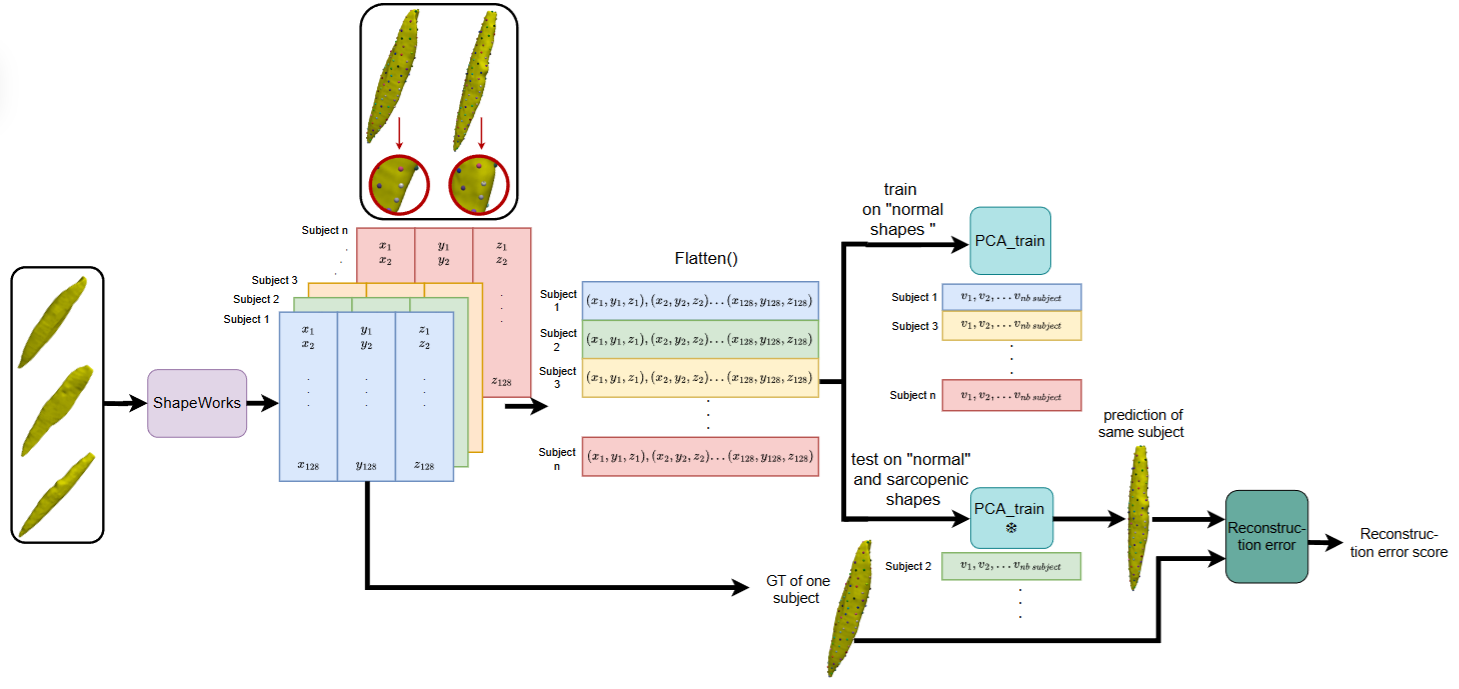 
*Illustration of the reconstruction error computation using a PCA model trained on normal shapes.*


### Selection of PCA Components

In the reconstruction error approach, the **number of retained PCA components** plays a crucial role.

* If too few components are used, the constructed space does not capture enough variability, leading to overly approximate reconstructions.
* If too many components are retained, the model may overfit the data, and the distinction between groups may become less pronounced.

It is therefore necessary to select an **optimal number of components**: one that enables accurate shape reconstruction while maximizing **separation between groups**.
In our case, this choice is particularly important for distinguishing older subjects with sarcopenia from older subjects without sarcopenia.


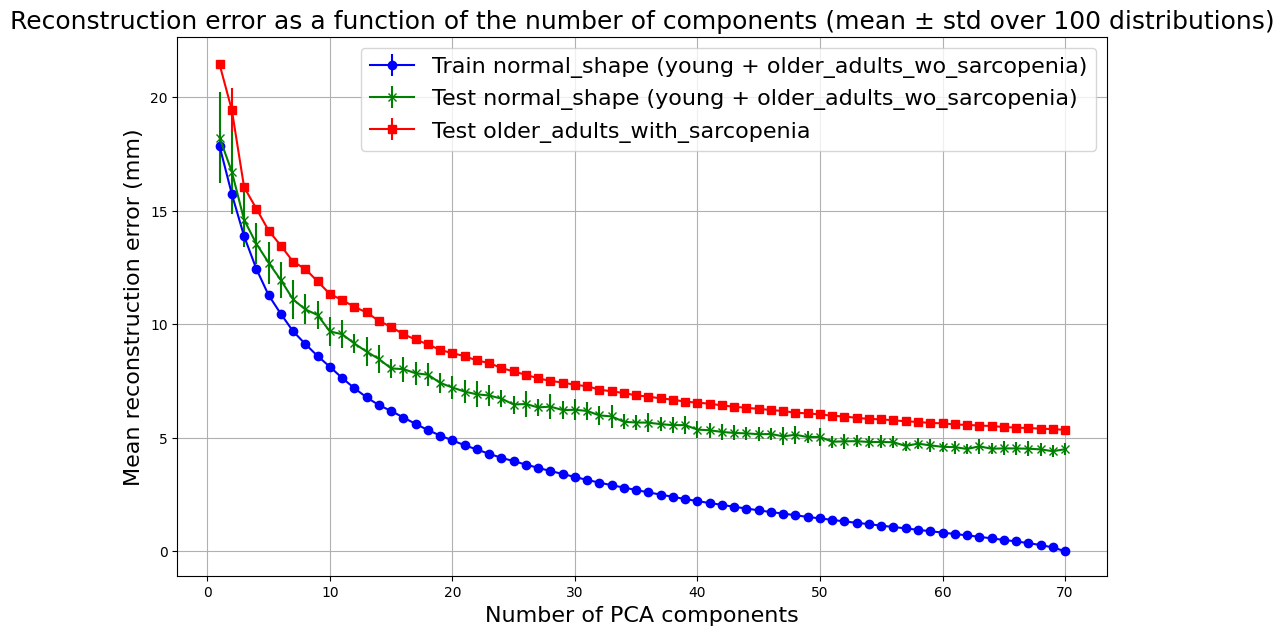

Meilleur écart moyen entre les formes normales et sarcopéniques pour la composante PCA n°1 (index 0)


In [ ]:
# RF : Répertoires des particules pour le muscle RF (Rectus Femoris)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# # TA : Répertoires pour le muscle TA (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL : Répertoires pour le muscle VL (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
# 1. Chargement des données
# Chargement des particules pour chaque groupe (sarcopénie, jeunes, vieux)
# sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
# n, p, d = sarcopenie_parts_128.shape  # n: nombre d'échantillons, p: nombre de points, d: dimension (3D)
# sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)  # Aplatir pour PCA

# jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
# n, p, d = jeunes_parts_128.shape
# jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)

# vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
# n, p, d = vieu_parts_128.shape
# vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Initialization of lists to store reconstruction errors
errors_train_tot = []
errors_test_tot = []
errors_sarcoppenie_tot = []
errors_vieux_tot = []

# Preparation for plotting mean reconstruction error and standard deviation as a function of the number of PCA components
parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
n_components_list = np.arange(1, min(int(parts_flat_128.shape[0] * 0.9), parts_flat_128.shape[1]), 1)

mean_errors_train = []
std_errors_train = []
mean_errors_test = []
std_errors_test = []
mean_errors_sarcopenie = []
std_errors_sarcopenie = []
mean_errors_vieux = []
std_errors_vieux = []

distribution = 30  # Number of random splits used to compute mean and standard deviation

for n_components in n_components_list:
    errors_train_dist = []
    errors_test_dist = []
    errors_sarcopenie_dist = []
    errors_vieux_dist = []
    for i in range(distribution):
        # Combine young and older (without sarcopenia) data
        parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
        label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: young, 1: older

        # Stratified train/test split
        X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(
            parts_flat_128, label_128, test_size=0.1, stratify=label_128
        )
        label_sarcopenie = np.array([2] * len(sarcopenie_parts_flat_128))  # 2: sarcopenia

        # PCA trained on training data
        pca = PCA(n_components=n_components)
        pca.fit(X_train_128)

        # Function to compute reconstruction error
        def reconstruction_error(X, model):
            X_reduced = model.transform(X)
            X_rec = model.inverse_transform(X_reduced)
            return np.linalg.norm(X - X_rec, axis=1)

        # Reconstruction errors for each group
        errors_train = reconstruction_error(X_train_128, pca)
        errors_test = reconstruction_error(X_test_128, pca)
        errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat_128, pca)

        # Mean error for this distribution
        errors_train_dist.append(np.mean(errors_train))
        errors_test_dist.append(np.mean(errors_test))
        errors_sarcopenie_dist.append(np.mean(errors_sarcopenie))

    # Mean and standard deviation over all distributions for each number of components
    mean_errors_train.append(np.mean(errors_train_dist))
    std_errors_train.append(np.std(errors_train_dist))
    mean_errors_test.append(np.mean(errors_test_dist))
    std_errors_test.append(np.std(errors_test_dist))
    mean_errors_sarcopenie.append(np.mean(errors_sarcopenie_dist))
    std_errors_sarcopenie.append(np.std(errors_sarcopenie_dist))

# Plot reconstruction error curves
plt.figure(figsize=(12, 7))
plt.errorbar(
    n_components_list, mean_errors_train, yerr=std_errors_train,
    label='Train normal_shape (young + older_adults_wo_sarcopenia)',
    marker='o', color='blue'
)
plt.errorbar(
    n_components_list, mean_errors_test, yerr=std_errors_test,
    label='Test normal_shape (young + older_adults_wo_sarcopenia)',
    marker='x', color='green'
)
plt.errorbar(
    n_components_list, mean_errors_sarcopenie, yerr=std_errors_sarcopenie,
    label='Test older_adults_with_sarcopenia',
    marker='s', color='red'
)

plt.xlabel("Number of PCA components", fontsize=16)
plt.ylabel("Mean reconstruction error (mm)", fontsize=16)
plt.title(
    "Reconstruction error as a function of the number of components "
    "(mean ± std over 100 distributions)",
    fontsize=18
)
plt.legend(fontsize=16)
plt.grid()
plt.savefig(
    "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_all_compenants_VL.pdf",
    format='pdf', bbox_inches='tight'
)
plt.show()

# Difference between normal and sarcopenic reconstruction errors
dif = np.array(mean_errors_test) - np.array(mean_errors_sarcopenie)

# Find the PCA component with the largest mean difference between normal and sarcopenic shapes
best_idx = np.argmax(np.abs(dif))
print(
    f"Largest mean difference between normal and sarcopenic shapes "
    f"for PCA component #{n_components_list[best_idx]} (index {best_idx})"
)


moyenne d'âge sains : 51.95
moyenne d'âge sarcopenie : 88.00
Erreur de reconstruction moyenne : 9.7746
Erreur de reconstruction moyenne : 12.4958
Erreur de reconstruction moyenne : 13.9816


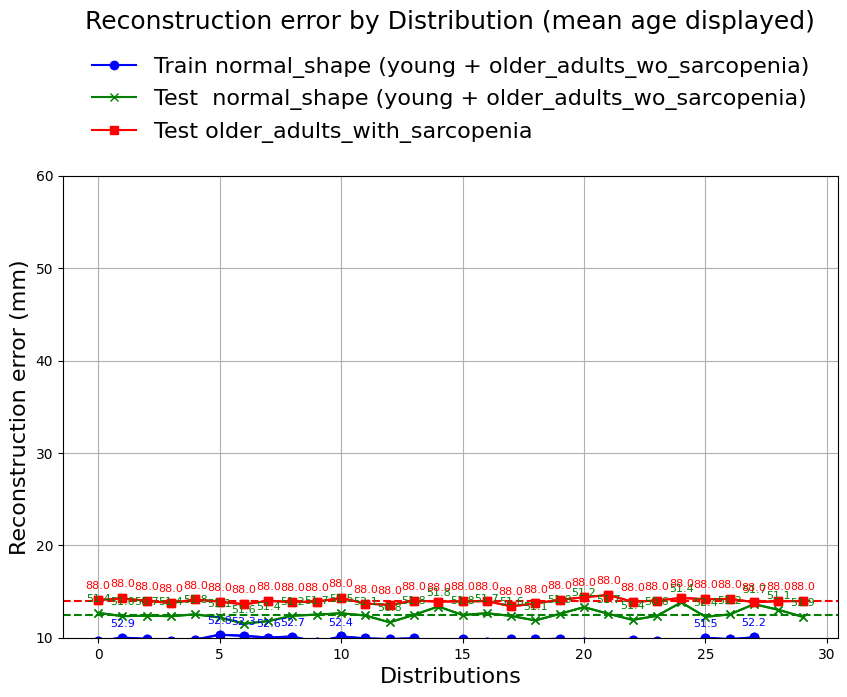

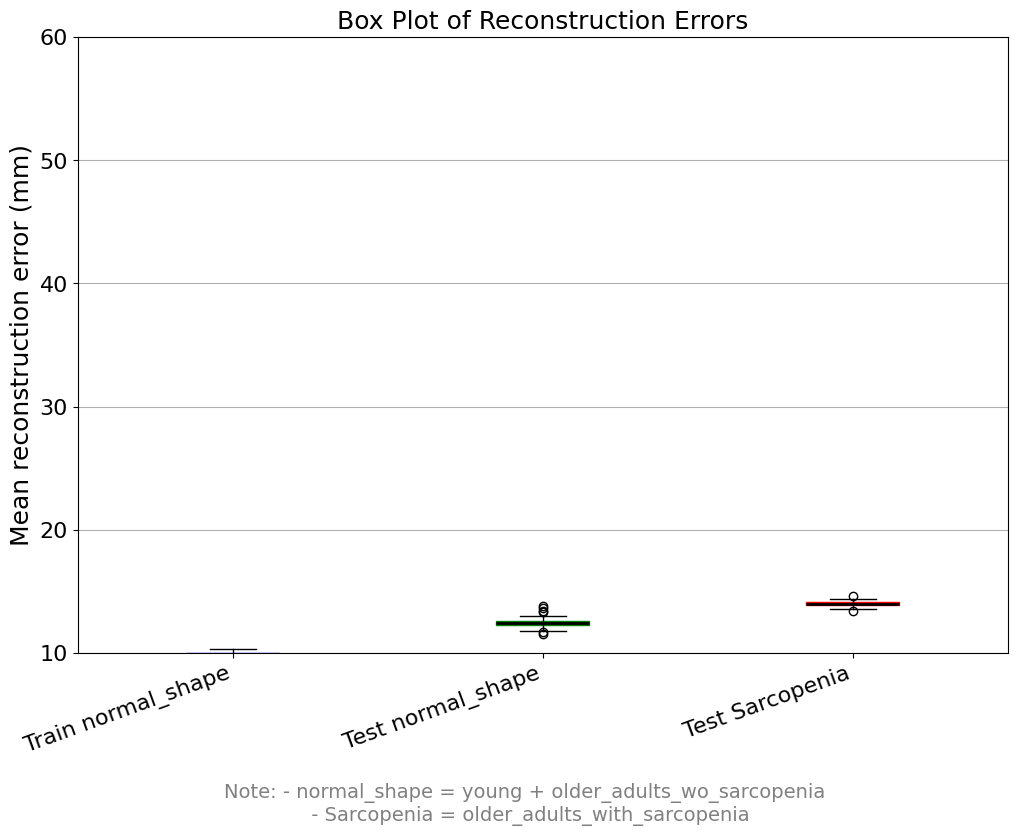

In [ ]:
# Load the Excel file containing ages (replace the path with yours)
excel_path = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/age_global.xlsx"
df_ages = pd.read_excel(excel_path)

# Assume the subject ID column is called 'ID_subject' and the age column is 'Age'
# Associate ages with sarcopenia, young, and older subjects
def get_ages(names, df_ages):
    ages = []

    for name in names:
        match_id = None
        # Look for an ID_subject from the DataFrame that is contained in the subject name
        for id_ in df_ages['ID_subject']:
            if id_.split("_")[0] in name.split("_"):
                match_id = id_
                break
        if match_id:
            age = df_ages.loc[df_ages['ID_subject'] == match_id, 'Age'].values[0]
            ages.append(age)
        else:
            print(f"ID not found for: {name}")
            ages.append(None)

    # Convert ages to int (ignoring None values)
    ages = [int(age) if age is not None else None for age in ages]
    return ages

# RF: Particle directories for the RF muscle (Rectus Femoris)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# TA: Particle directories for the TA muscle (Tibialis Anterior)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL: Particle directories for the VL muscle (Vastus Lateralis)
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"

# 1. Data loading
# Load particles and subject names for each group (sarcopenia, young, older)
sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # n: number of subjects, p: number of points, d: dimension (3D)
ages_sarcopenie = get_ages(sarcopenie_names, df_ages)
sarcopenie_parts_flat_128 = (sarcopenie_parts_128.reshape(n, -1), sarcopenie_names, ages_sarcopenie)

jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape
ages_jeunes = get_ages(jeunes_names, df_ages)
jeunes_parts_flat_128 = (jeunes_parts_128.reshape(n, -1), jeunes_names, ages_jeunes)

vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape
ages_vieux = get_ages(vieu_names, df_ages)
vieu_parts_flat_128 = (vieu_parts_128.reshape(n, -1), vieu_names, ages_vieux)

# Compute valid ages (non-None) for healthy and sarcopenia groups
ages_sains = jeunes_parts_flat_128[2] + vieu_parts_flat_128[2]
X_ages_valid = [age for age in ages_sains if age is not None]
sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat_128[2] if age is not None]
print(f"Mean age (healthy): {np.mean(X_ages_valid):.2f}")
print(f"Mean age (sarcopenia): {np.mean(sarcopenie_ages_valid):.2f}")

# Initialize lists to store errors and mean ages
errors_train_tot = []
errors_test_tot = []
errors_sarcoppenie_tot = []
errors_jeunes_tot = []
train_ages_means = []
test_ages_means = []
sarcopenie_ages_means = []
jeunes_ages_means = []
distribution = 30

# 2. Split young and older subjects into train/test
for i in range(distribution):
    # Combine young and older data for the split
    X_data = np.vstack((jeunes_parts_flat_128[0], vieu_parts_flat_128[0]))
    X_names = jeunes_parts_flat_128[1] + vieu_parts_flat_128[1]
    X_ages = jeunes_parts_flat_128[2] + vieu_parts_flat_128[2]
    label_128 = np.array([0] * len(jeunes_parts_flat_128[0]) + [1] * len(vieu_parts_flat_128[0]))  # 0: young, 1: older

    label_sarcopenie = np.array([2] * len(sarcopenie_parts_flat_128[0]))  # 2: sarcopenia

    # Train/test split (50/50, stratified)
    X_train_128, X_test_128, y_train_128, y_test_128, train_names, test_names, train_ages, test_ages = train_test_split(
        X_data, label_128, X_names, X_ages, test_size=0.5, stratify=label_128
    )

    # 3. PCA
    n_components = 6  # 6 for RF and 2 for TA: number of principal components retained
    pca = PCA(n_components=n_components)
    pca.fit(X_train_128)

    # 4. Reconstruction function + error
    def reconstruction_error(X, model):
        X_reduced = model.transform(X)
        X_rec = model.inverse_transform(X_reduced)
        return np.linalg.norm(X - X_rec, axis=1)  # L2 error per sample

    # 5. Reconstruction error computation for each group
    errors_train = reconstruction_error(X_train_128, pca)
    errors_test = reconstruction_error(X_test_128, pca)
    errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat_128[0], pca)

    # Compute valid mean ages for each split
    train_ages_valid = [age for age in train_ages if age is not None]
    test_ages_valid = [age for age in test_ages if age is not None]
    sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat_128[2] if age is not None]

    train_ages_means.append(np.mean(train_ages_valid) if train_ages_valid else np.nan)
    test_ages_means.append(np.mean(test_ages_valid) if test_ages_valid else np.nan)
    sarcopenie_ages_means.append(np.mean(sarcopenie_ages_valid) if sarcopenie_ages_valid else np.nan)

    # Store errors for later analysis
    errors_train_tot.append(errors_train)
    errors_test_tot.append(errors_test)
    errors_sarcoppenie_tot.append(errors_sarcopenie)
    errors_train = []
    errors_test = []
    errors_sarcopenie = []

print(f"Mean reconstruction error (train): {np.mean(errors_train_tot):.4f}")
print(f"Mean reconstruction error (test): {np.mean(errors_test_tot):.4f}")
print(f"Mean reconstruction error (sarcopenia): {np.mean(errors_sarcoppenie_tot):.4f}")

# 6. Plot reconstruction errors by split/distribution
plt.figure(figsize=(10, 6))
x = range(distribution)
plt.plot(x, [np.mean(err) for err in errors_train_tot], label='Train normal_shape (young + older_adults_wo_sarcopenia)', marker='o', color='blue')
plt.plot(x, [np.mean(err) for err in errors_test_tot], label='Test normal_shape (young + older_adults_wo_sarcopenia)', marker='x', color='green')
plt.plot(x, [np.mean(err) for err in errors_sarcoppenie_tot], label='Test older_adults_with_sarcopenia', marker='s', color='red')

# Display mean age on each point
for i in x:
    plt.annotate(f"{train_ages_means[i]:.1f}", (i, np.mean(errors_train_tot[i])), textcoords="offset points", xytext=(0,8), ha='center', color='blue', fontsize=8)
    plt.annotate(f"{test_ages_means[i]:.1f}", (i, np.mean(errors_test_tot[i])), textcoords="offset points", xytext=(0,8), ha='center', color='green', fontsize=8)
    plt.annotate(f"{sarcopenie_ages_means[i]:.1f}", (i, np.mean(errors_sarcoppenie_tot[i])), textcoords="offset points", xytext=(0,8), ha='center', color='red', fontsize=8)

plt.axhline(y=np.mean([np.mean(err) for err in errors_train_tot]), color='blue', linestyle='--')
plt.axhline(y=np.mean([np.mean(err) for err in errors_test_tot]), color='green', linestyle='--')
plt.axhline(y=np.mean([np.mean(err) for err in errors_sarcoppenie_tot]), color='red', linestyle='--')

plt.xlabel("Distributions", fontsize=16)
plt.ylabel("Reconstruction error (mm)", fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), frameon=False, fontsize=16)
plt.title("Reconstruction error by distribution (mean age displayed)", fontsize=18, y=1.3)
plt.ylim(10, 60)
plt.grid()
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_by_distribution_VL.pdf", format='pdf', bbox_inches='tight')
plt.show()

# 7. Display reconstruction errors as a boxplot
plt.figure(figsize=(12, 8))

data = [
    [np.mean(err) for err in errors_train_tot],
    [np.mean(err) for err in errors_test_tot],
    [np.mean(err) for err in errors_sarcoppenie_tot],
]

labels = [
    "Train normal_shape",
    "Test normal_shape",
    "Test Sarcopenia"
]

colors = ["blue", "green", "red"]

bp = plt.boxplot(data, labels=labels, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)

for median, color in zip(bp['medians'], colors):
    median.set(color='black', linewidth=2)  # black median for contrast

plt.title("Box plot of reconstruction errors", fontsize=18)
plt.ylabel("Mean reconstruction error (mm)", fontsize=18)

plt.gca().tick_params(axis='x', labelrotation=20)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_fontsize(16)
    tick.set_horizontalalignment('right')

plt.ylim(5, 40)
plt.grid(axis="y")
plt.figtext(
    0.5, -0.1,
    "Note: - normal_shape = young + older_adults_wo_sarcopenia\n"
    "- Sarcopenia = older_adults_with_sarcopenia",
    ha="center", fontsize=14, color="gray"
)

plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_box_plot_VL.pdf", format='pdf', bbox_inches='tight')
plt.show()


### Combined box plot display


#### for one fold

Train RF shape: (6, 40)
Test RF shape: (6, 40)
Sarcopenie RF shape: (6, 24)
size errors_train_tot_RF: (24,)
size errors_train_tot_RF: (22,)
size errors_train_tot_RF: (23,)
     Muscle      Error       Group   Fold      Subject
0        RF  51.750074     healthy  Fold1   RF_test_S1
1        RF  57.917417     healthy  Fold1   RF_test_S2
2        RF  60.797036     healthy  Fold1   RF_test_S3
3        RF  54.422045     healthy  Fold1   RF_test_S4
4        RF  74.803194     healthy  Fold1   RF_test_S5
...     ...        ...         ...    ...          ...
1117     VL  40.255130  sarcopenia  Fold6  VL_sarc_S19
1118     VL  24.706636  sarcopenia  Fold6  VL_sarc_S20
1119     VL  30.901872  sarcopenia  Fold6  VL_sarc_S21
1120     VL  28.864102  sarcopenia  Fold6  VL_sarc_S22
1121     VL  45.061321  sarcopenia  Fold6  VL_sarc_S23

[1122 rows x 5 columns]

--- LMM Results for RF (healthy + sarcopenia) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Va

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


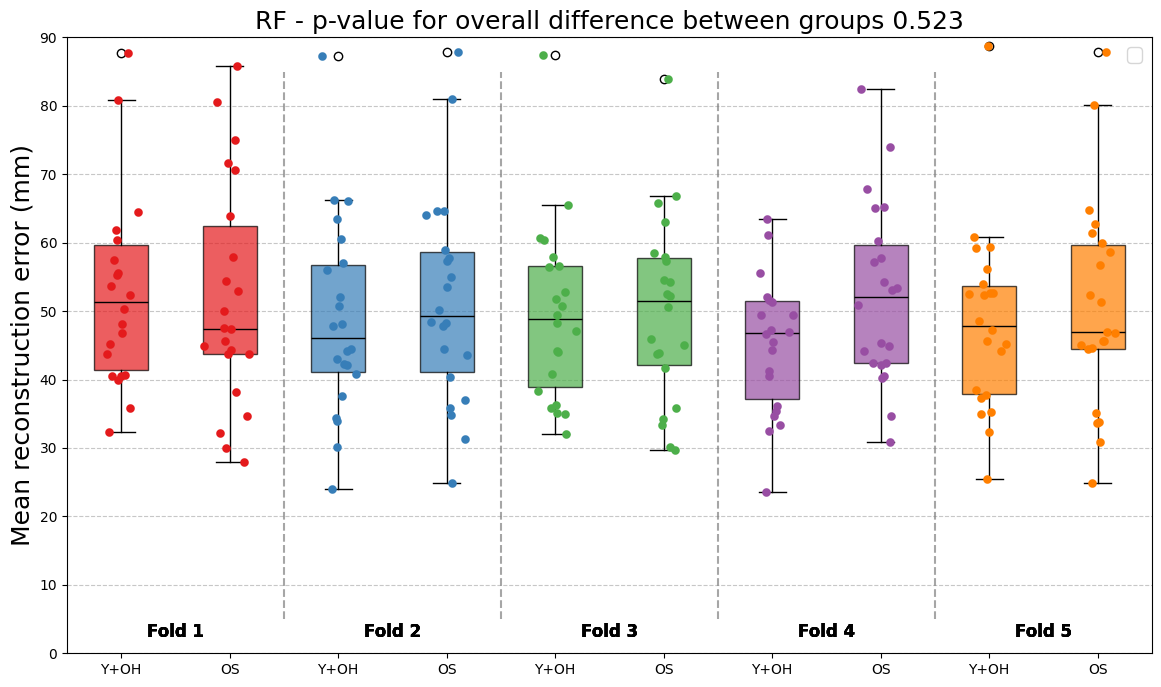

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


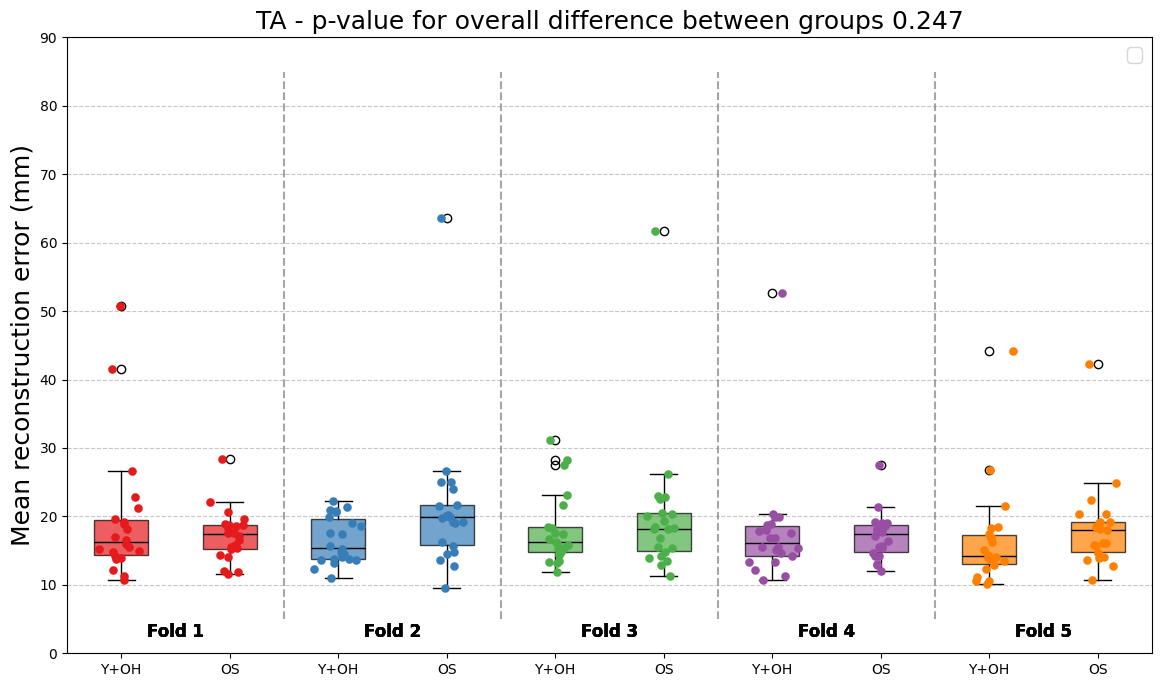

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


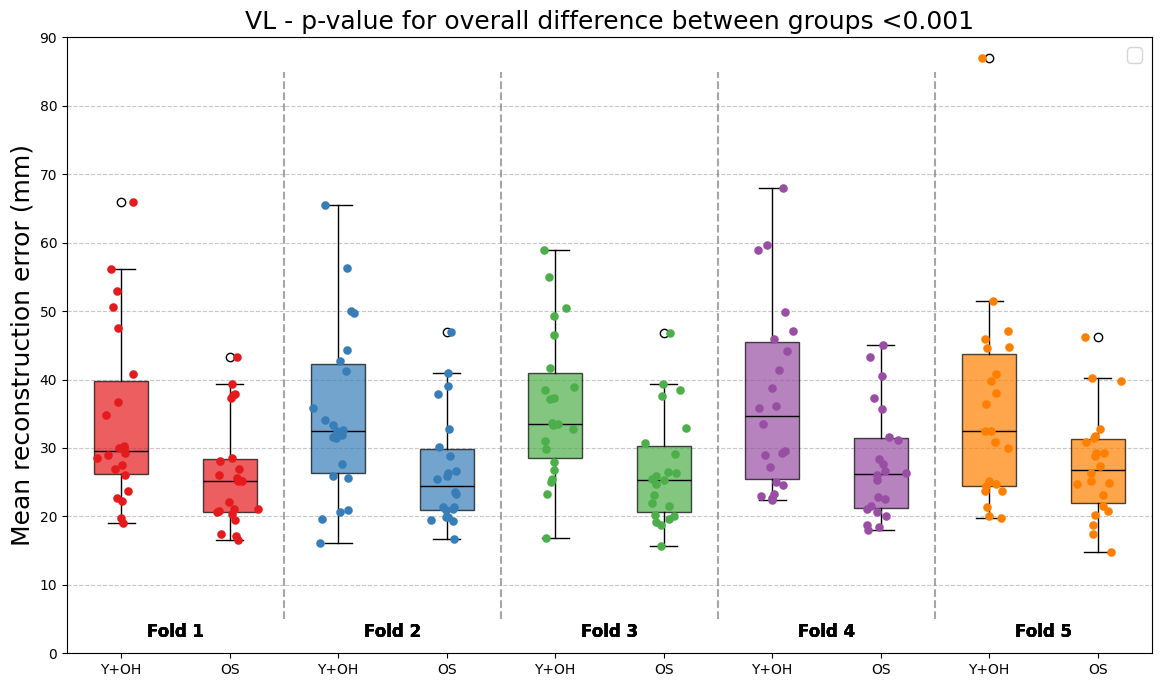

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def compute_reconstruction_errors(particles_dir_sarcopenie, particles_dir_jeunes, particles_dir_vieux, df_ages, distribution=30, n_components=6):
    """
    Computes PCA reconstruction errors for different particle groups.

    Args:
        particles_dir_sarcopenie (str): Directory containing sarcopenia particle files.
        particles_dir_jeunes (str): Directory containing young subjects particle files.
        particles_dir_vieux (str): Directory containing older subjects particle files.
        df_ages (DataFrame): DataFrame containing subject ages.
        distribution (int, optional): Number of train/test splits to perform. Default is 30.
        n_components (int, optional): Number of principal components for PCA. Default is 6.

    Returns:
        dict: Dictionary containing reconstruction errors and mean ages.
"""

    
    # --- Loading data ---
    sarcopenie_parts, sarcopenie_names = get_particles(particles_dir_sarcopenie, "world")
    n, p, d = sarcopenie_parts.shape
    ages_sarcopenie = get_ages(sarcopenie_names, df_ages)
    sarcopenie_parts_flat = (sarcopenie_parts.reshape(n, -1), sarcopenie_names, ages_sarcopenie)

    jeunes_parts, jeunes_names = get_particles(particles_dir_jeunes, "world")
    n, p, d = jeunes_parts.shape
    ages_jeunes = get_ages(jeunes_names, df_ages)
    jeunes_parts_flat = (jeunes_parts.reshape(n, -1), jeunes_names, ages_jeunes)

    vieux_parts, vieux_names = get_particles(particles_dir_vieux, "world")
    n, p, d = vieux_parts.shape
    ages_vieux = get_ages(vieux_names, df_ages)
    vieux_parts_flat = (vieux_parts.reshape(n, -1), vieux_names, ages_vieux)

    # --- Reconstruction function and error calculation ---
    def reconstruction_error(X, model):
        X_reduced = model.transform(X)
        X_rec = model.inverse_transform(X_reduced)
        return np.linalg.norm(X - X_rec, axis=1)
    
    # Initialize lists to store results
    errors_train_tot = []
    errors_test_tot = []
    errors_sarcopenie_tot = []
    train_ages_means = []
    test_ages_means = []
    sarcopenie_ages_means = []

    # --- Loop over splits ---
    for _ in range(distribution):
        X_data = np.vstack((jeunes_parts_flat[0], vieux_parts_flat[0]))
        X_names = jeunes_parts_flat[1] + vieux_parts_flat[1]
        X_ages = jeunes_parts_flat[2] + vieux_parts_flat[2]
        label_128 = np.array([0] * len(jeunes_parts_flat[0]) + [1] * len(vieux_parts_flat[0]))

        # Split train/test
        X_train, X_test, y_train, y_test, train_names, test_names, train_ages, test_ages = train_test_split(
            X_data, label_128, X_names, X_ages, test_size=0.5, stratify=label_128
        )

        # PCA
        pca = PCA(n_components=n_components)
        pca.fit(X_train)

        # Compute errors
        errors_train = reconstruction_error(X_train, pca)
        errors_test = reconstruction_error(X_test, pca)
        errors_sarcopenie = reconstruction_error(sarcopenie_parts_flat[0], pca)

        # Valid age means
        train_ages_valid = [age for age in train_ages if age is not None]
        test_ages_valid = [age for age in test_ages if age is not None]
        sarcopenie_ages_valid = [age for age in sarcopenie_parts_flat[2] if age is not None]

        train_ages_means.append(np.mean(train_ages_valid) if train_ages_valid else np.nan)
        test_ages_means.append(np.mean(test_ages_valid) if test_ages_valid else np.nan)
        sarcopenie_ages_means.append(np.mean(sarcopenie_ages_valid) if sarcopenie_ages_valid else np.nan)

        # Store errors
        errors_train_tot.append(errors_train)
        errors_test_tot.append(errors_test)
        errors_sarcopenie_tot.append(errors_sarcopenie)

    return {
        "errors_train": errors_train_tot,
        "errors_test": errors_test_tot,
        "errors_sarcopenie": errors_sarcopenie_tot,
        "train_ages_means": train_ages_means,
        "test_ages_means": test_ages_means,
        "sarcopenie_ages_means": sarcopenie_ages_means
    }




# Load Excel file containing ages
excel_path = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/age_global.xlsx"
df_ages = pd.read_excel(excel_path)

# Function to associate ages with names
def get_ages(names, df_ages):
    ages = []
    for name in names:
        match_id = None
        for id_ in df_ages['ID_subject']:
            if id_.split("_")[0] in name.split("_"):
                match_id = id_
                break
        if match_id:
            age = df_ages.loc[df_ages['ID_subject'] == match_id, 'Age'].values[0]
            ages.append(age)
        else:
            print(f"ID not found for: {name}")
            ages.append(None)
    return [int(age) if age is not None else None for age in ages]

# Data paths (adapt according to desired muscle)
particles_dir_RF = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_TA = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"
}
particles_dir_VL = {
    "vieux": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Ages_128",
    "jeunes": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Jeunes_128",
    "sarcopenie": "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_VL_test30/Run_1/OUTPUT/Sarcopenie_128"
}


# Call the function
errors_dict_RF = compute_reconstruction_errors(
    particles_dir_RF["sarcopenie"],
    particles_dir_RF["jeunes"],
    particles_dir_RF["vieux"],
    df_ages=df_ages,
    distribution=6,
    n_components=2
)

errors_dict_TA = compute_reconstruction_errors(
    particles_dir_TA["sarcopenie"],
    particles_dir_TA["jeunes"],
    particles_dir_TA["vieux"],
    df_ages=df_ages,
    distribution=6,
    n_components=2
)

errors_dict_VL = compute_reconstruction_errors(
    particles_dir_VL["sarcopenie"],
    particles_dir_VL["jeunes"],
    particles_dir_VL["vieux"],
    df_ages=df_ages,
    distribution=6,
    n_components=2
)

# Retrieve errors for each muscle
errors_train_tot_RF = errors_dict_RF["errors_train"]
errors_test_tot_RF = errors_dict_RF["errors_test"]
errors_sarcopenie_tot_RF = errors_dict_RF["errors_sarcopenie"]

errors_train_tot_TA = errors_dict_TA["errors_train"]
errors_test_tot_TA = errors_dict_TA["errors_test"]
errors_sarcopenie_tot_TA = errors_dict_TA["errors_sarcopenie"]

errors_train_tot_VL = errors_dict_VL["errors_train"]
errors_test_tot_VL = errors_dict_VL["errors_test"]
errors_sarcopenie_tot_VL = errors_dict_VL["errors_sarcopenie"]

# Check shapes to ensure everything is correct
print("Train RF shape:", np.array(errors_train_tot_RF).shape)
print("Test RF shape:", np.array(errors_test_tot_RF).shape)
print("Sarcopenie RF shape:", np.array(errors_sarcopenie_tot_RF).shape)


# # Mean errors (example with RF, adapt according to your variables)
# mean_errors_train_muscle = [
#     [np.mean(err) for err in errors_train_tot_RF],
#     [np.mean(err) for err in errors_train_tot_TA],
#     [np.mean(err) for err in errors_train_tot_VL],
# ]

# mean_errors_test_muscle = [
#     [np.mean(err) for err in errors_test_tot_RF],
#     [np.mean(err) for err in errors_test_tot_TA],
#     [np.mean(err) for err in errors_test_tot_VL],
# ]

# mean_errors_sarcopenie_muscle = [
#     [np.mean(err) for err in errors_sarcopenie_tot_RF],
#     [np.mean(err) for err in errors_sarcopenie_tot_TA],
#     [np.mean(err) for err in errors_sarcopenie_tot_VL],
# ]

print("size errors_train_tot_RF:", errors_sarcopenie_tot_RF[0].shape)
print("size errors_train_tot_RF:", errors_sarcopenie_tot_TA[0].shape)
print("size errors_train_tot_RF:", errors_sarcopenie_tot_VL[0].shape)
# Mean errors for the first distribution only
mean_errors_train_muscle = [
    errors_train_tot_RF[1][:22],    # first RF distribution
    errors_train_tot_TA[1][:22],    # first TA distribution
    errors_train_tot_VL[1][:22],    # first VL distribution
]

mean_errors_test_muscle = [
    errors_test_tot_RF[1][:22],     # first RF distribution
    errors_test_tot_TA[1][:22],     # first TA distribution
    errors_test_tot_VL[1][:22],     # first VL distribution
]

mean_errors_sarcopenie_muscle = [
    errors_sarcopenie_tot_RF[1][:22],   # first RF distribution
    errors_sarcopenie_tot_TA[1][:22],   # first TA distribution
    errors_sarcopenie_tot_VL[1][:22],   # first VL distribution
]


muscle_labels = ['RF', 'TA', 'VL']
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# def calculate_LMM()
# --- Concatenate all errors into a single DataFrame ---
records = []
p_value_group = []
for i, muscle in enumerate(muscle_labels):
    # Test
    for fold_idx, err_fold in enumerate(errors_test_tot_RF if muscle=="RF" else errors_test_tot_TA if muscle=="TA" else errors_test_tot_VL):
        for subj_idx, err in enumerate(err_fold):
            records.append({
                "Muscle": muscle,
                "Error": err,
                "Group": "healthy",
                "Fold": f"Fold{fold_idx+1}",
                "Subject": f"{muscle}_test_S{subj_idx+1}"
            })
    # Sarcopenia
    for fold_idx, err_fold in enumerate(errors_sarcopenie_tot_RF if muscle=="RF" else errors_sarcopenie_tot_TA if muscle=="TA" else errors_sarcopenie_tot_VL):
        for subj_idx, err in enumerate(err_fold):
            records.append({
                "Muscle": muscle,
                "Error": err,
                "Group": "sarcopenia",
                "Fold": f"Fold{fold_idx+1}",
                "Subject": f"{muscle}_sarc_S{subj_idx+1}"
            })

df_test_sarc = pd.DataFrame.from_records(records)
print(df_test_sarc)

# Convert to categorical for statsmodels
df_test_sarc["Group"] = df_test_sarc["Group"].astype("category")
df_test_sarc["Fold"] = df_test_sarc["Fold"].astype("category")
df_test_sarc["Subject"] = df_test_sarc["Subject"].astype("category")

# --- LMM per muscle only on test and sarcopenia ---
lmm_results = {}
for muscle in muscle_labels:
    df_m = df_test_sarc[df_test_sarc["Muscle"] == muscle]
    model = mixedlm("Error ~ Group + Fold", df_m, groups=df_m["Subject"])
    result = model.fit()
    print(f"\n--- LMM Results for {muscle} (healthy + sarcopenia) ---")
    print(result.summary())
    lmm_results[muscle] = result
    p_value = result.pvalues["Group[T.sarcopenia]"]
    print(f"Exact p-value for Group effect (healthy vs sarcopenia): {p_value:.6f}")
    p_value_group.append("<0.001" if p_value < 0.001 else f"{p_value:.3f}")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score

def plot_global_roc_all_muscles_with_eval(
    errors_test_tot_RF, errors_sarcopenie_tot_RF,
    errors_test_tot_TA, errors_sarcopenie_tot_TA,
    errors_test_tot_VL, errors_sarcopenie_tot_VL,
    muscle_labels=["RF", "TA", "VL"]
):
    """
    Calcule et trace les courbes ROC pour RF, TA, VL,
    puis évalue les performances par fold avec le seuil global ROC.
    """

    # --- 1. Build the global DataFrame ---
    records = []
    for muscle in muscle_labels:
        # Groupe healthy
        for fold_idx, err_fold in enumerate(
            errors_test_tot_RF if muscle == "RF" else
            errors_test_tot_TA if muscle == "TA" else
            errors_test_tot_VL
        ):
            for subj_idx, err in enumerate(err_fold):
                records.append({
                    "Muscle": muscle,
                    "Error": err,
                    "Group": "healthy",
                    "Fold": fold_idx + 1
                })

        # Groupe sarcopenia
        for fold_idx, err_fold in enumerate(
            errors_sarcopenie_tot_RF if muscle == "RF" else
            errors_sarcopenie_tot_TA if muscle == "TA" else
            errors_sarcopenie_tot_VL
        ):
            for subj_idx, err in enumerate(err_fold):
                records.append({
                    "Muscle": muscle,
                    "Error": err,
                    "Group": "sarcopenia",
                    "Fold": fold_idx + 1
                })

    df_all = pd.DataFrame.from_records(records)

    # --- 2. Global ROC per muscle ---
    roc_results = {}
    plt.figure(figsize=(8, 6))
    colors = {"RF": "darkorange", "TA": "seagreen", "VL": "royalblue"}

    for muscle in muscle_labels:
        # Muscle-specific data
        df_m = df_all[df_all["Muscle"] == muscle]
        y_true = (df_m["Group"] == "sarcopenia").astype(int).values
        y_score = df_m["Error"].values

        # Compute ROC curve and optimal threshold
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        youden_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[youden_index]

        roc_results[muscle] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc,
            "threshold": optimal_threshold,
            "sensitivity": tpr[youden_index],
            "specificity": 1 - fpr[youden_index]
        }

        # --- Console output ---
        print(f"\n--- {muscle} ---")
        print(f"AUC = {roc_auc:.4f}")
        print(f"Optimal error threshold = {optimal_threshold:.4f}")
        print(f"Sensitivity (TPR) = {tpr[youden_index]:.3f}")
        print(f"Specificity (1 - FPR) = {1 - fpr[youden_index]:.3f}")

        # --- Individual plot ---
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color=colors[muscle], lw=2, label=f"AUC = {roc_auc:.2f}")
        plt.scatter(
            fpr[youden_index], tpr[youden_index],
            color=colors[muscle], edgecolor='black', s=100, marker='o',
            label=f"Optimal threshold = {optimal_threshold:.2f}"
        )
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
        plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
        plt.title(f'ROC Curve - {muscle} (Healthy vs Sarcopenia)', fontsize=16)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Optional saving
        plt.savefig(
                f"C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/ROC_{muscle}_PC6.pdf",
                format='pdf',
                bbox_inches='tight'
            )
        plt.show()


    # --- 3. Evaluation by fold with global threshold ---
    print("\n==========================================")
    print("   EVALUATION BY FOLD WITH GLOBAL THRESHOLD")
    print("==========================================\n")

    fold_eval_results = {}

    for muscle in muscle_labels:
        threshold = roc_results[muscle]["threshold"]
        fold_metrics = []

        for fold in sorted(df_all["Fold"].unique()):
            df_fold = df_all[(df_all["Muscle"] == muscle) & (df_all["Fold"] == fold)]

            y_true = (df_fold["Group"] == "sarcopenia").astype(int).values
            y_pred = (df_fold["Error"] > threshold).astype(int)

            # Compute metrics
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()
            acc = accuracy_score(y_true, y_pred)
            sens = recall_score(y_true, y_pred)
            spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
            prec = precision_score(y_true, y_pred)
            fpr, tpr, _ = roc_curve(y_true, y_fold_score := df_fold["Error"].values)
            auc_fold = auc(fpr, tpr)

            fold_metrics.append({
                "Fold": fold,
                "Accuracy": acc,
                "Sensitivity": sens,
                "Specificity": spec,
                "Precision": prec,
                "AUC": auc_fold
            })

        df_metrics = pd.DataFrame(fold_metrics)
        fold_eval_results[muscle] = df_metrics

        print(f"✅ Summary of per-fold performance ({muscle}):")
        display(df_metrics)
        print("Mean ± std:")
        display(df_metrics.describe().loc[["mean", "std"]])
        print("\n")

    return roc_results, fold_eval_results


# roc_results, fold_eval_results = plot_global_roc_all_muscles_with_eval(
#     errors_test_tot_RF, errors_sarcopenie_tot_RF,
#     errors_test_tot_TA, errors_sarcopenie_tot_TA,
#     errors_test_tot_VL, errors_sarcopenie_tot_VL
# )



muscle_labels = ['RF', 'TA', 'VL']
muscle_colors = sns.color_palette("Set1", n_colors=5)

# # --- Figure 1: Error by distribution for each muscle ---
# plt.figure(figsize=(12, 7))
# for idx, muscle in enumerate(muscle_labels):
#     x = range(len(mean_errors_train_muscle[idx]))
#     plt.plot(x, mean_errors_train_muscle[idx], label=f'Train {muscle}', marker='o', color=muscle_colors[idx])
#     plt.plot(x, mean_errors_test_muscle[idx], label=f'Test {muscle}', marker='x', linestyle='--', color=muscle_colors[idx])
#     plt.plot(x, mean_errors_sarcopenie_muscle[idx], label=f'Sarcopenia {muscle}', marker='s', linestyle=':', color=muscle_colors[idx])
#
# plt.xlabel("Distributions", fontsize=16)
# plt.ylabel("Reconstruction error (mm)", fontsize=16)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False, fontsize=14)
# plt.title("Reconstruction error by Distribution for RF, TA, VL", fontsize=18, y=1.08)
# plt.ylim(10, 60)
# plt.grid()
# plt.savefig("error_by_distribution_RF_TA_VL.pdf", format='pdf', bbox_inches='tight')
# plt.show()

print("size mean_errors_train_muscle:", [len(m) for m in mean_errors_train_muscle][0])
print("size mean_errors_train_muscle:", [len(m) for m in mean_errors_test_muscle][0])
print("size mean_errors_train_muscle:", [len(m) for m in mean_errors_sarcopenie_muscle][0])
# --- Figure 2: Boxplot of errors ---

data_box = (
    mean_errors_train_muscle[0] + mean_errors_test_muscle[0] + mean_errors_sarcopenie_muscle[0] +
    mean_errors_train_muscle[1] + mean_errors_test_muscle[1] + mean_errors_sarcopenie_muscle[1] +
    mean_errors_train_muscle[2] + mean_errors_test_muscle[2] + mean_errors_sarcopenie_muscle[2]
)

# labels_box = [
#     "Train RF", "Test RF", "Sarcopenia RF",
#     "Train TA", "Test TA", "Sarcopenia TA",
#     "Train VL", "Test VL", "Sarcopenia VL"
# ]
# colors_box = muscle_colors[0:1]*3 + muscle_colors[1:2]*3 + muscle_colors[2:3]*3


# labels_box = [
#     "Fold1 Y+OH", "Fold1 OS",
#     "Fold2 Y+OH", "Fold2 OS",
#     "Fold3 Y+OH", "Fold3 OS",
#     "Fold4 Y+OH", "Fold4 OS",
#     "Fold5 Y+OH", "Fold5 OS",
# ]

labels_box = [
    "Y+OH", "OS",
    "Y+OH", "OS",
    "Y+OH", "OS",
    "Y+OH", "OS",
    "Y+OH", "OS",
]

colors_box = muscle_colors[0:1]*2 + muscle_colors[1:2]*2 + muscle_colors[2:3]*2+ muscle_colors[3:4]*2 + muscle_colors[4:5]*2

# Restructure data by group
# data = [
#     mean_errors_train_muscle[0], mean_errors_test_muscle[0], mean_errors_sarcopenie_muscle[0],
#     mean_errors_train_muscle[1], mean_errors_test_muscle[1], mean_errors_sarcopenie_muscle[1],
#     mean_errors_train_muscle[2], mean_errors_test_muscle[2], mean_errors_sarcopenie_muscle[2]
# ]

data = [[
    errors_test_tot_RF[1][:22],errors_sarcopenie_tot_RF[1][:22],
    errors_test_tot_RF[2][:22],errors_sarcopenie_tot_RF[2][:22],
    errors_test_tot_RF[3][:22],errors_sarcopenie_tot_RF[3][:22],
    errors_test_tot_RF[4][:22],errors_sarcopenie_tot_RF[4][:22],
    errors_test_tot_RF[5][:22],errors_sarcopenie_tot_RF[5][:22]],
    [
    errors_test_tot_TA[1][:22],errors_sarcopenie_tot_TA[1][:22],
    errors_test_tot_TA[2][:22],errors_sarcopenie_tot_TA[2][:22],
    errors_test_tot_TA[3][:22],errors_sarcopenie_tot_TA[3][:22],
    errors_test_tot_TA[4][:22],errors_sarcopenie_tot_TA[4][:22],
    errors_test_tot_TA[5][:22],errors_sarcopenie_tot_TA[5][:22]],
    [
    errors_test_tot_VL[1][:22],errors_sarcopenie_tot_VL[1][:22],
    errors_test_tot_VL[2][:22],errors_sarcopenie_tot_VL[2][:22],
    errors_test_tot_VL[3][:22],errors_sarcopenie_tot_VL[3][:22],
    errors_test_tot_VL[4][:22],errors_sarcopenie_tot_VL[4][:22],
    errors_test_tot_VL[5][:22],errors_sarcopenie_tot_VL[5][:22]]
]

for i in range(len(data)):
    plt.figure(figsize=(14, 8))
    bp = plt.boxplot(data[i], labels=labels_box, patch_artist=True)

    # --- Boxplot colors and style ---
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_alpha(0.7)
    for median in bp['medians']:
        median.set(color='black', linewidth=1)

    # --- Add individual points (jitter) ---
    for u, group_data in enumerate(data[i]):
        x_jitter = np.random.normal(loc=u + 1, scale=0.08, size=len(group_data))
        plt.scatter(x_jitter, group_data, color=colors_box[u], alpha=1, s=10, linewidth=3, zorder=3)

    # # --- Add the threshold from ROC results ---
    muscle = muscle_labels[i]
    # threshold = roc_results[muscle]["threshold"]

    # --- Dashed lines between folds ---
    ymin, ymax = plt.ylim(0, 90)
    for fold in range(1, 5):
        x_pos = fold * 2 + 0.5  # separate each fold
        plt.vlines(x=x_pos, ymin=ymin+5, ymax=ymax-5, colors="grey", linestyles="--", alpha=0.7)

    # -------------------- FOLD LABELS --------------------
        label_y = ymin + 0.05 * (ymax - ymin)
        for fold in range(5):
            mid = 2 * fold + 1.5
            plt.text(
                mid,
                label_y,
                f"Fold {fold+1}",
                ha="center",
                va="top",
                fontsize=12,
                fontweight="bold"
            ) 


    # --- Titles and style ---
    plt.title(f"{muscle} - p-value for overall difference between groups {p_value_group[i]}",
              fontsize=18)
    plt.ylabel("Mean reconstruction error (mm)", fontsize=18)
    plt.xticks(rotation=0, ha='center')
    # plt.yticks(fontsize=14)
    plt.ylim(0, 90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=14, loc="upper right")

    # --- Save ---
    plt.savefig(
        f"C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/reconstruction_error/error_folds_{muscle}_PC2.pdf",
        format='pdf',
        bbox_inches='tight'
    )
    plt.show()


## Supervised Classification

This method aims to build a predictive model to automatically classify a subject into three categories:  
- **young**,  
- **older (without sarcopenia)**,  
- **older (with sarcopenia)**,  
based on muscle shape.

The pipeline includes:  
1. A **PCA** applied to the shapes to capture overall variability.  
2. An **LDA** to improve class separability and reduce dimensionality.  
3. Training a **logistic regression** classifier on the reduced space to predict a new subject's category.

This approach both evaluates the relevance of information contained in muscle shape and proposes an automatic classification method that could potentially be used in clinical practice.

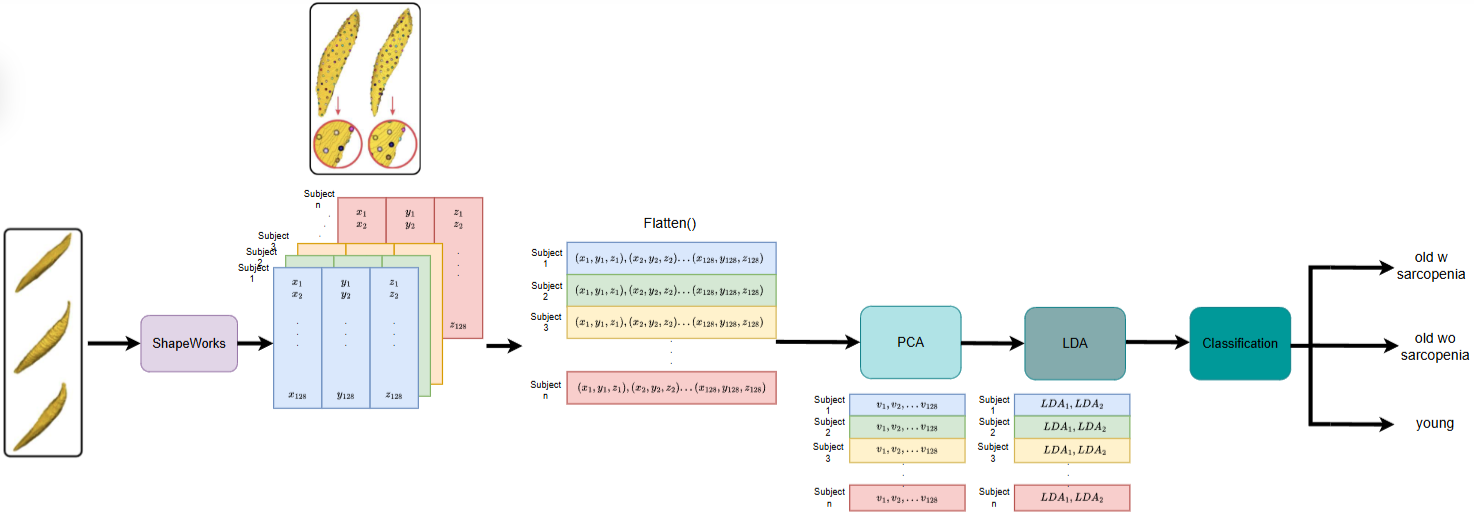  
*Supervised classification pipeline for subjects into three groups based on correspondence points.*


In [ ]:
# Creation of new synthetic data
def augment_data(data, n_augment=2):
    # Ensure the input data is a NumPy array
    data = np.array(data)
    augmented_data = []
    for i in range(n_augment):
        noise = np.random.normal(loc=0, scale=noise_level, size=data.shape)
        augmented_data.append(data + noise)
    return np.vstack(augmented_data)


# RF
particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Ages_128"
particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Jeunes_128"
particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_RF6/Run_1/OUTPUT/Sarcopenie_128"

# TA
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_128_TA/Run_1/OUTPUT/Sarcopenie_128"

# VL
# particles_dir_vieu_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_version1/D_J_128_VL/Run_1/OUTPUT/Ages_128"
# particles_dir_jeunes_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_version1/D_J_128_VL/Run_1/OUTPUT/Jeunes_128"
# particles_dir_sarcopenie_128 = "C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Code/D_J_version1/D_J_128_VL/Run_1/OUTPUT/Sarcopenie_128"

sarcopenie_parts_128, sarcopenie_names = get_particles(particles_dir_sarcopenie_128, "world")
n, p, d = sarcopenie_parts_128.shape  # d is the dimensionality of each particle
sarcopenie_parts_flat_128 = sarcopenie_parts_128.reshape(n, -1)
jeunes_parts_128, jeunes_names = get_particles(particles_dir_jeunes_128, "world")
n, p, d = jeunes_parts_128.shape  # d is the dimensionality of each particle
jeunes_parts_flat_128 = jeunes_parts_128.reshape(n, -1)
vieu_parts_128, vieu_names = get_particles(particles_dir_vieu_128, "world")
n, p, d = vieu_parts_128.shape  # d is the dimensionality of each particle
vieu_parts_flat_128 = vieu_parts_128.reshape(n, -1)

# Noise parameter (should be adjusted according to your data)
noise_level = 0.05  


# Generation of new synthetic observations
# jeunes_parts_flat_128 = augment_data(jeunes_parts_flat_128, n_augment=2)  # Augment young x2
# vieu_parts_flat_128 = augment_data(vieu_parts_flat_128, n_augment=2)  # Augment old x2
# sarcopenie_parts_flat_128 = augment_data(sarcopenie_parts_flat_128, n_augment=2)  # Augment sarcopenia x2

accuracy_tot=[]
score_tot=[]
y_true=[]
y_pred=[]
y_prob = []
y_true_tab=[]
y_pred_tab=[]
y_prob_tab = []
true=[]
pred = []
prob = []
aff_score= []
aff_score_tab = []
log_reg_coef_tab=[]
log_reg_coef = []
lda_coef_tab=[]
lda_coef = []
pca_coef_tab=[]

distribution = 30 # number of dataset ensembles to generate
for iteration in range(distribution):
    # Combine data for young and old
    parts_flat_128 = np.vstack((jeunes_parts_flat_128, vieu_parts_flat_128))
    label_128 = np.array([0] * len(jeunes_parts_flat_128) + [1] * len(vieu_parts_flat_128))  # 0: young, 1: old, 2: sarcopenia
    # print(f"parts_flat_128 shape: {parts_flat_128.shape[0]} samples, {parts_flat_128.shape[1]} features")

    # Split data into training and testing sets (80% train, 20% test)
    X_train_128, X_test_128, y_train_128, y_test_128 = train_test_split(parts_flat_128, label_128, test_size=0.2, stratify=label_128)#, random_state=42)
    label_sarcopenie = np.array([2] * len(sarcopenie_parts_flat_128))  # 0: young, 1: old, 2: sarcopenia
    X_train_sarcopenie, X_test_sarcopenie, y_train_sarcopenie, y_test_sarcopenie = train_test_split(sarcopenie_parts_flat_128, label_sarcopenie, test_size=0.3)#, random_state=42)
    X_train_128 = np.vstack((X_train_128, X_train_sarcopenie))
    X_test_128 = np.vstack((X_test_128, X_test_sarcopenie))
    
    y_train_128 =  np.concatenate((y_train_128, y_train_sarcopenie))
    y_test_128 = np.concatenate((y_test_128, y_test_sarcopenie))

    # y_train_128 = np.random.randint(0, 3, size=len(X_train_128))  # Generate random labels between 0 and 2
    # y_test_128 = np.random.randint(0, 3, size=len(X_test_128))  # Generate random labels between 0 and 2
    # print(y_train_128.shape)
    # print(y_train_sarcopenie.shape)
    
    # X_augmented1 = generate_shapes(jeunes_parts_flat_128, num_particles=128, n_new=9, n_components=len(jeunes_parts_flat_128), variation_scale=3.0)
    # X_augmented2 = generate_shapes(vieu_parts_flat_128, num_particles=128, n_new=7, n_components=len(vieu_parts_flat_128), variation_scale=3.0)
    # X_augmented3 = generate_shapes(sarcopenie_parts_flat_128, num_particles=128, n_new=7, n_components=len(sarcopenie_parts_flat_128), variation_scale=3.0)    
    
    # X_train_128 = np.concatenate((X_train_128, X_augmented1, X_augmented2, X_augmented3))
    # y_train_128 =  np.concatenate((y_train_128, np.array([0] * len(X_augmented1) + [1] * len(X_augmented2)+ [2] * len(X_augmented3))))  # 0: young, 1: old, 2: sarcopenia
    
    print(f"train set size: {len(X_train_128)}, test set size: {len(X_test_128)}")
    print(f"X_train_128 shape: {X_train_128.shape[0]} samples, {X_train_128.shape[1]} features")
    # print(X_train_128.shape)
    # print(y_train_128.shape)

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_train_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    print(f"train num young: {count_jeunes}, num old: {count_vieux}, num sarcopenia: {count_sarcopenie}")

    count_jeunes=0
    count_vieux=0
    count_sarcopenie=0
    for i in y_test_128:
        if i==0:
            count_jeunes+=1
        elif i==1:
            count_vieux+=1
        elif i==2:
            count_sarcopenie+=1
    print(f"test num young: {count_jeunes}, num old: {count_vieux}, num sarcopenia: {count_sarcopenie}")

    # Train PCA on the training data
    # Adjust n_components to be less than or equal to min(n_samples, n_features)

    max_components = min(X_train_128.shape[0], X_train_128.shape[1])
    print(f"max_components : {max_components}")
    scores_64 = []
    scores_128 = []
    k_neighbors = 5  # Number of neighbors for kNN
    cv_folds = 20  # Number of folds for cross-validation


    # print(f"Training PCA with {max_components} components")
    component_range = range(2, max_components + 1) 
    pca_128 = PCA(n_components=max_components)
    X_pca_128 = pca_128.fit_transform(X_train_128)


    for n in component_range:
        
        # max_components = 100

        # Ensure n_components for LDA is valid

        lda_128 = LDA(n_components=2)
        lda_projection_128 = lda_128.fit_transform(X_pca_128[:, :n], y_train_128)
        
        # Evaluate with kNN
        
        # X_pca_test_128 = pca_128.transform(X_test_128)
        # X_lda_test_128 = lda_128.transform(X_pca_test_128[:, :n])
        # score = silhouette_score(X_lda_test_128, y_test_128)
        # scores_128.append(score)
        # y_true.append(y_test_128)
        # y_pred.append(y_pred_128)
        # y_prob.append(log_reg_128.predict_proba(X_lda_test_128))
        # print(f"64 Particles , PCA={n} -> Accuracy kNN: {score:.4f}")

        # Train Logistic Regression on 128 particles
        X_pca_test_128 = pca_128.transform(X_test_128)
        X_lda_test_128 = lda_128.transform(X_pca_test_128[:, :n])
        log_reg_128 = LogisticRegression(max_iter=10000, random_state=42)
        log_reg_128.fit(lda_projection_128, y_train_128)

        # Test Logistic Regression on 128 particles
        
        y_pred_128 = log_reg_128.predict(X_lda_test_128)
        accuracy = accuracy_score(y_test_128, y_pred_128)
        # accuracy = balanced_accuracy_score(y_test_128, y_pred_128) 
        f1 = f1_score(y_test_128, y_pred_128, average='micro')
        # print(f"F1_score : {f1:.4f}")
        recall = recall_score(y_test_128, y_pred_128, average='macro')
        f1_per_class = f1_score(y_test_128, y_pred_128, average=None)
        # print(f"F1_score per class : {f1_per_class}")
        # print(f"report : {classification_report(y_test_128, y_pred_128)}")
        recall_per_class = recall_score(y_test_128, y_pred_128, average=None)
        # accuracy_per_class = [accuracy_score(y_test_128[y_test_128 == i], y_pred_128[y_test_128 == i]) for i in np.unique(y_test_128)]
        accuracy_per_class = precision_score(y_test_128, y_pred_128, average=None, zero_division=0)

        # print(f"accuracy per class : {accuracy_per_class}")

        scores_128.append(f1)
        y_true_tab.append(y_test_128)
        y_pred_tab.append(y_pred_128)
        y_prob_tab.append(log_reg_128.predict_proba(X_lda_test_128))
        aff_score.append([f1, recall,accuracy, f1_per_class[0],f1_per_class[1], f1_per_class[2], 
                          recall_per_class[0], recall_per_class[1], recall_per_class[2], 
                          accuracy_per_class[0], accuracy_per_class[1], accuracy_per_class[2]])
        log_reg_coef.append(log_reg_128)
        lda_coef.append(lda_128)
    print(f"Best Component : {component_range[np.argmax(scores_128)]}, score: {max(scores_128):.4f}")
    score_tot.append(scores_128)
    true.append(y_true_tab)
    pred.append(y_pred_tab)
    prob.append(y_prob_tab)
    aff_score_tab.append(aff_score)
    aff_score = []
    scores_128 = []
    print(f" LDA coef size : {len(lda_coef)}")
    
    log_reg_coef_tab.append(log_reg_coef)
    log_reg_coef = []
    lda_coef_tab.append(lda_coef)
    lda_coef = []
    pca_coef_tab.append(pca_128)
print(f"log reg size : {len(lda_coef_tab)}")
# Find the optimal number of components
moyennes_scores = np.mean(score_tot, axis=0)
best_n_components_128 = component_range[np.argmax(moyennes_scores)]
best_score = max(moyennes_scores)
print(f"128 Particles ,Best Component : {best_n_components_128}, score: {best_score:.4f}\n")
# Extract scores corresponding to the best number of components
best_scores = [scores[component_range.index(best_n_components_128)] for scores in score_tot]
# best_pca_coef = [scores[component_range.index(best_n_components_128)] for scores in pca_coef_tab]
best_reg_coef = [scores[component_range.index(best_n_components_128)] for scores in log_reg_coef_tab]
best_lda_coef = [scores[component_range.index(best_n_components_128)] for scores in lda_coef_tab]
y_true =  [scores[component_range.index(best_n_components_128)] for scores in true]
y_pred =  [scores[component_range.index(best_n_components_128)] for scores in pred]
y_prob =  [scores[component_range.index(best_n_components_128)] for scores in prob]
# Convert to a NumPy array for easier manipulation if needed
best_scores_array = np.array(best_scores)


# Calculate means and standard deviations for each metric across distributions
metrics = np.array(aff_score_tab)  # Convert to NumPy array for easier calculations
means = metrics.mean(axis=0)  # Mean for each metric
stds = metrics.std(axis=0)  # Standard deviation for each metric

# Extract the metrics
accuracy_means = means[:, 2]*100
recall_means = means[:, 1]*100
f1_score_means = means[:, 0]*100
accuracy_stds = stds[:, 2]*100
recall_stds = stds[:, 1]*100
f1_score_stds = stds[:, 0]*100

f1_score_means_jeunes = means[:,3]*100
f1_score_means_vieux = means[:, 4]*100
f1_score_means_sarcopenie = means[:, 5]*100
f1_score_stds_jeunes = stds[:, 3]*100
f1_score_stds_vieux = stds[:, 4]*100
f1_score_stds_sarcopenie = stds[:, 5]*100

recall_means_jeunes = means[:,6]*100
recall_means_vieux = means[:, 7]*100
recall_means_sarcopenie = means[:, 8]*100
recall_stds_jeunes = stds[:, 6]*100
recall_stds_vieux = stds[:, 7]*100
recall_stds_sarcopenie = stds[:, 8]*100

accuracy_means_jeunes = means[:,9]*100
accuracy_means_vieux = means[:, 10]*100
accuracy_means_sarcopenie = means[:, 11]*100
accuracy_stds_jeunes = stds[:, 9]*100
accuracy_stds_vieux = stds[:, 10]*100
accuracy_stds_sarcopenie = stds[:, 11]*100

# Create indices for the distributions
x = np.arange(1, len(accuracy_means) + 1)

# Plot curves with a semi-transparent band for the standard deviation
plt.figure(figsize=(10, 6))
# plt.plot(x, accuracy_means, label="Accuracy", color='blue')
# plt.fill_between(x, accuracy_means - accuracy_stds, accuracy_means + accuracy_stds, color='blue', alpha=0.2)

# plt.plot(x, recall_means, label="Recall", color='green')
# plt.fill_between(x, recall_means - recall_stds, recall_means + recall_stds, color='green', alpha=0.2)

plt.plot(x, accuracy_means, label="Accuracy Moyenne", color='gold', linestyle='--')
plt.fill_between(x, accuracy_means - accuracy_stds, accuracy_means + accuracy_stds, color='gold', alpha=0.2)
plt.plot(x, accuracy_means_jeunes, label="Accuracy Jeunes", color='blue')
plt.fill_between(x, accuracy_means_jeunes - accuracy_stds_jeunes, accuracy_means_jeunes + accuracy_stds_jeunes, color='blue', alpha=0.2)
plt.plot(x,accuracy_means_vieux, label="Accuracy Ages", color='green')
plt.fill_between(x, accuracy_means_vieux - accuracy_stds_vieux, accuracy_means_vieux + accuracy_stds_vieux, color='green', alpha=0.2)
plt.plot(x, accuracy_means_sarcopenie, label="Accuracy Sarcopénie", color='red')
plt.fill_between(x, accuracy_means_sarcopenie - accuracy_stds_sarcopenie, accuracy_means_sarcopenie + accuracy_stds_sarcopenie, color='red', alpha=0.2)
# Ajouter des labels et une légende
# plt.title("Accuracy :  Moyenne et écart-type par nombre decomposantes")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Score de classification (%)")
plt.legend()
plt.grid(True)
# Sauvegarder la figure en PDF
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Classification_supervisee/Accuracy_RF.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x,recall_means, label="Recall Moyenne", color='gold', linestyle='--')
plt.fill_between(x, recall_means - recall_stds, recall_means + recall_stds, color='gold', alpha=0.2)
plt.plot(x, recall_means_jeunes, label="Recall Jeunes", color='blue')
plt.fill_between(x, recall_means_jeunes - recall_stds_jeunes,recall_means_jeunes + recall_stds_jeunes, color='blue', alpha=0.2)
plt.plot(x, recall_means_vieux, label="Recall Ages", color='green')
plt.fill_between(x, recall_means_vieux - recall_stds_vieux, recall_means_vieux + recall_stds_vieux, color='green', alpha=0.2)
plt.plot(x, recall_means_sarcopenie, label="Recall Sarcopénie", color='red')
plt.fill_between(x, recall_means_sarcopenie - recall_stds_sarcopenie, recall_means_sarcopenie + recall_stds_sarcopenie, color='red', alpha=0.2)
# Ajouter des labels et une légende
plt.title("Recall :  Moyenne et écart-type par nombre decomposantes")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Score de classification (%)")
plt.legend()
plt.grid(True)
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Classification_supervisee/Recall_RF.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, f1_score_means, label="F1-Score Moyenne", color='gold', linestyle='--')
plt.fill_between(x, f1_score_means - f1_score_stds, f1_score_means + f1_score_stds, color='gold', alpha=0.2)
plt.plot(x, f1_score_means_jeunes, label="F1-Score Jeunes", color='blue')
plt.fill_between(x, f1_score_means_jeunes - f1_score_stds_jeunes, f1_score_means_jeunes + f1_score_stds_jeunes, color='blue', alpha=0.2)
plt.plot(x, f1_score_means_vieux, label="F1-Score Ages", color='green')
plt.fill_between(x, f1_score_means_vieux - f1_score_stds_vieux, f1_score_means_vieux + f1_score_stds_vieux, color='green', alpha=0.2)
plt.plot(x, f1_score_means_sarcopenie, label="F1-Score Sarcopénie", color='red')
plt.fill_between(x, f1_score_means_sarcopenie - f1_score_stds_sarcopenie, f1_score_means_sarcopenie + f1_score_stds_sarcopenie, color='red', alpha=0.2)
# Ajouter des labels et une légende
plt.title("F1-Score : Moyenne et écart-type par nombre decomposantes")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Score de classification (%)")
plt.legend()
plt.grid(True)
plt.savefig("C:/Users/gossa/OneDrive/Documents/Travail INSA Lyon/PFE/Figure Article/Classification_supervisee/F1_score_RF.pdf", format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(component_range, moyennes_scores * 100, label="F1-Score Moyen", color='blue', marker='o')
plt.axvline(x=best_n_components_128, color='red', linestyle='--', label=f"Meilleure Composante: {best_n_components_128}")
plt.title("Nombre de Composantes PCA vs F1-Score")
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("F1-Score (%)")
plt.legend()
plt.grid(True)
plt.show()


print("Classification Report (128 particles):")
print(f"128 Particles ,Best Component : {best_n_components_128}")
print("Average F1-Score : ", np.mean(best_scores_array) * 100)
print("Standard Deviation : ", np.std(best_scores_array) * 100)

pca_128 = PCA(n_components=max_components)
X_pca_128 = pca_128.fit_transform(X_train_128)
lda_128 = LDA(n_components=2)
lda_projection_128 = lda_128.fit_transform(X_pca_128[:, :best_n_components_128], y_train_128)

# Train Logistic Regression on 128 particles
X_pca_test_128 = pca_128.transform(X_test_128)
X_lda_test_128 = lda_128.transform(X_pca_test_128[:, :best_n_components_128])
log_reg_128 = LogisticRegression(max_iter=10000, random_state=42)
log_reg_128.fit(lda_projection_128, y_train_128)

# Test Logistic Regression on 128 particles
y_pred_128 = log_reg_128.predict(X_lda_test_128)

plt.figure(figsize=(8, 6))
for label, label_str, color in zip([0, 1, 2], ['jeunes', 'âgés', 'sarcopenie'], ['blue', 'green', 'red']):
    correct = (y_test_128 == y_pred_128) & (y_test_128 == label)
    incorrect = (y_test_128 != y_pred_128) & (y_test_128 == label)
    plt.scatter(X_lda_test_128[correct, 0], X_lda_test_128[correct, 1], c=color, label=f'{label_str} (correct)', alpha=0.7, marker='o')
    plt.scatter(X_lda_test_128[incorrect, 0], X_lda_test_128[incorrect, 1], c=color, label=f'{label_str} (incorrect)', alpha=0.7, marker='x')
    plt.scatter(lda_projection_128[y_train_128 == label, 0], lda_projection_128[y_train_128 == label, 1], c=color, label=f'{label_str} (train)', alpha=0.3, marker='s')

plt.title(f"Exemple : Régression Logistique sur les données Train et Test , F1-Score : {np.mean(best_scores_array)*100:.1f}%")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True)
plt.show()


y_pred=np.concatenate(y_pred)
y_true=np.concatenate(y_true)
# print(f"y_true= {y_true}")
# print(f"y_pred= {y_pred}")
print(classification_report(y_true, y_pred))
# Conversion en pourcentage par rapport au total
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100

# Affichage avec seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Jeunes","Âgés","Sarcopénique"], yticklabels=["Jeunes","Âgés","Sarcopénique"])
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion (%)")
plt.show()

# Binarisation des étiquettes réelles
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Calcul de la courbe ROC et de l’AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

# Convert y_prob to a NumPy array
y_prob_array = np.vstack(y_prob)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Ajouter la ligne diagonale
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Ajouter des labels et une légende
plt.title("Courbe ROC multi-classes")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# On binarise (one-hot) les prédictions (manuellement ici, car ce ne sont pas des probabilités)
# Cela suppose que la classe prédite a une proba 1.0
y_pred_proba = label_binarize(y_pred, classes=[0, 1, 2])

# Calcul du log loss
loss = log_loss(y_true, y_pred_proba, labels=[0, 1, 2])
print("Log loss :", loss)


### Affichage variations PCA par distributions

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# We assume pca_coef_tab contains all your PCAs (one per distribution)
# We take the first PCA for the mean shape
mean_shape = pca_coef_tab[0].mean_  # (n_features,)
n_points = mean_shape.shape[0] // 3

# For each distribution, we display the variation on the 1st component
sigmas = [-3, -1.5, 0, 1.5, 3]
fig = plt.figure(figsize=(18, 4 * len(pca_coef_tab)))


numéro_composantes = 0

# for idx, pca in enumerate(pca_coef_tab[:len(pca_coef_tab)]):
for idx, pca in enumerate(pca_coef_tab[:5]):
    std = np.sqrt(pca.explained_variance_[numéro_composantes])
    eigenvector = pca.components_[numéro_composantes]
    mean_shape = pca.mean_  # (n_features,)
    n_points = mean_shape.shape[0] // 3
    for i, s in enumerate(sigmas):
        shape_mod = mean_shape + s * std * eigenvector
        pts = shape_mod.reshape((n_points, 3))
        # Compute the distance to the mean shape for each point
        mean_pts = mean_shape.reshape((n_points, 3))
        distances = np.linalg.norm(pts - mean_pts, axis=1)
        # Normalize distances for the colorbar
        norm_distances = (distances - distances.min()) / (np.ptp(distances) + 1e-8)
        ax = fig.add_subplot(len(pca_coef_tab), len(sigmas), idx * len(sigmas) + i + 1, projection='3d')
        scatter = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=norm_distances, cmap='viridis', s=10)
        ax.set_title(f'Distrib {idx+1}, {s}σ')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('equal')
        ax.set_box_aspect([1,1,1])
        # Zoom: tighten limits for a closer focus
        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 100)
        ax.set_zlim(-100, 100)
        # Add a colorbar for each subplot
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, pad=0.05)
        cbar.set_label("Distance to mean (normalized)")
plt.tight_layout()
plt.show()

### Visualizing the influence of PCA components on LDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Basic parameters
n_distributions = len(best_reg_coef)
n_components_pca = pca_128.n_components_
n_classes = best_reg_coef[0].coef_.shape[0]

# List to store influence [n_distributions, n_pca, n_classes]
influence_distributions = []

for log_reg_128, lda_128 in zip(best_reg_coef, best_lda_coef):
    W_logreg = log_reg_128.coef_  # [n_classes, n_lda]
    W_lda = lda_128.scalings_[:, :lda_128.n_components]  # [n_pca, n_lda]
    
    # Influence propagated back to PCA components
    W_pca_to_logreg = W_lda @ W_logreg.T  # [n_pca, n_classes]
    
    # Absolute value = importance
    W_pca_influence = np.abs(W_pca_to_logreg)  # [n_pca, n_classes]
    
    # Normalization in percentage per class
    W_pca_influence_percent = 100 * W_pca_influence / np.sum(W_pca_influence, axis=0, keepdims=True)  # [n_pca, n_classes]

    influence_distributions.append(W_pca_influence_percent)

# Stack into [n_distributions, n_pca, n_classes]
influence_array = np.stack(influence_distributions, axis=0)

# Mean and standard deviation: [n_pca, n_classes]
influence_mean = np.mean(influence_array, axis=0)
influence_std = np.std(influence_array, axis=0)

# Display per class
x = np.arange(influence_mean.shape[0])
labels = [f"PC{i+1}" for i in x]

fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 6), sharey=True)
if n_classes == 1:
    axes = [axes]  # Handle the case of a single class

class_names = ["Young", "Older without sarcopenia", "Older with sarcopenia"]

for i in range(n_classes):
    axes[i].bar(x, influence_mean[:, i], yerr=influence_std[:, i], capsize=5, color=f'C{i}')
    axes[i].set_title(class_names[i])  # <-- Replace the title
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylabel("Mean influence (%)")

fig.suptitle("Mean influence of PCA components per class (with standard deviation)", fontsize=16)
plt.tight_layout()
plt.show()
